<a href="https://colab.research.google.com/github/ranrania3/BladderCancer-Scripts/blob/main/BCDataset_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import io
from google.colab import files
import os
from scipy.stats import chi2_contingency

In [2]:
first=pd.read_excel('/content/BC_dataset_efore_preprocessing.xlsx')
csv=pd.read_csv('/content/BC_dataset_efore_preprocessing - blca_tcga_clinical_data.csv')
second=pd.read_excel('/content/BC_dataset_final.xlsx')

In [3]:
df = first.copy()
df.dtypes

Patient ID                                                               object
Diagnosis Age                                                             int64
Prostate Cancer UICC TNM Stage                                           object
UICC Metastasis Stage Code                                               object
UICC TNM Tumor Stage Code                                                object
Angiolymphatic Invasion                                                  object
Disease Free (Months)                                                    object
Disease Free Status                                                      object
Family History Cancer Relationship                                       object
Neoplasm Histologic Grade                                                object
Neoadjuvant Therapy Type Administered Prior To Resection Text            object
Prior Cancer Diagnosis Occurence                                         object
Incidental Prostate Cancer Indicator                                     object
Karnofsky Performance Score                                             float64
Patient Metastatic Sites                                                 object
New Neoplasm Event Post Initial Therapy Indicator                        object
History of Noninvasive Bladder Cancer                                    object
Occupation Current                                                       object
Overall Survival (Months)                                                object
Overall Survival Status                                                  object
Adjuvant Postoperative Pharmaceutical Therapy Administered Indicator     object
Did patient start adjuvant postoperative radiotherapy?                   object
Sex                                                                      object
Patient Smoking History Category                                        float64
Person Neoplasm Status                                                   object
dtype: object

In [4]:
#detection des lignes contenant ≥ 50% de valeurs manquantes
df = first.copy()

# Nettoyer : retirer espaces + mettre en minuscule
df_cleaned = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

# Remplacer les cellules contenant exactement 'na' par pd.NA
df[df_cleaned == 'na'] = pd.NA

print("🔍 Détection des lignes contenant ≥ 50% de valeurs manquantes...\n")

# Nombre total de colonnes
total_cols = len(df.columns)

# Détection des lignes avec ≥ 50% de valeurs manquantes
missing_rows_summary = []

for i, row in df.iterrows():
    na_count = row.isna().sum()
    percentage = (na_count / total_cols) * 100
    if percentage >= 50:
        impact = (
            " Faible" if percentage < 5 else
            " Moyen" if 5 <= percentage <= 20 else
            " Élevé"
        )
        missing_rows_summary.append({
            "ligne": i + 2,  # +2 pour correspondre à la ligne réelle
            "nb_na": na_count,
            "percentage": round(percentage, 2),
            "impact": impact
        })

# Affichage
if missing_rows_summary:
    for item in missing_rows_summary:
        print(f"Ligne {item['ligne']}: {item['nb_na']} valeur(s) manquante(s) → {item['impact']} ({item['percentage']}%)")
    print(f"\n📌 Total : {len(missing_rows_summary)} ligne(s) avec ≥ 50% de valeurs manquantes.")
else:
    print("✅ Aucune ligne avec ≥ 50% de valeurs manquantes détectée.")

print("\n✅ Analyse terminée.")


🔍 Détection des lignes contenant ≥ 50% de valeurs manquantes...

Ligne 36: 14 valeur(s) manquante(s) →  Élevé (56.0%)
Ligne 37: 13 valeur(s) manquante(s) →  Élevé (52.0%)
Ligne 38: 13 valeur(s) manquante(s) →  Élevé (52.0%)
Ligne 41: 15 valeur(s) manquante(s) →  Élevé (60.0%)
Ligne 43: 13 valeur(s) manquante(s) →  Élevé (52.0%)
Ligne 54: 13 valeur(s) manquante(s) →  Élevé (52.0%)
Ligne 58: 13 valeur(s) manquante(s) →  Élevé (52.0%)

📌 Total : 7 ligne(s) avec ≥ 50% de valeurs manquantes.

✅ Analyse terminée.


<ipython-input-4-bd30fe03d9a9>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)


In [5]:
#Statistiques descriptives
df = first.copy()
nombre_lignes, nombre_colonnes = df.shape
print(f"Nombre de lignes : {nombre_lignes}")
print(f"Nombre de colonnes : {nombre_colonnes}")

stats = df.describe()
print(stats)

stats_selectionnees = df.describe().loc[['mean', '50%', 'std']]
stats_selectionnees.rename(index={'50%': 'median'}, inplace=True)
print(stats_selectionnees)

stats_selectionnees.to_excel("statistiques_descriptives.xlsx")

Nombre de lignes : 413
Nombre de colonnes : 25
       Diagnosis Age  Karnofsky Performance Score  \
count     413.000000                   136.000000   
mean       68.060533                    83.088235   
std        10.596011                    13.690478   
min        34.000000                    30.000000   
25%        60.000000                    80.000000   
50%        69.000000                    90.000000   
75%        76.000000                    90.000000   
max        90.000000                   100.000000   

       Patient Smoking History Category  
count                        400.000000  
mean                           2.462500  
std                            1.162744  
min                            1.000000  
25%                            1.000000  
50%                            2.000000  
75%                            3.000000  
max                            5.000000  
        Diagnosis Age  Karnofsky Performance Score  \
mean        68.060533                    83

In [6]:
df = pd.read_csv("/content/BC_dataset_efore_preprocessing - blca_tcga_clinical_data.csv")

# ➤ 3. Sélectionner les colonnes catégorielles (object or category)
cat_cols = df.select_dtypes(include=["object", "category"]).columns

# ➤ 4. Appliquer le test du Chi² pour chaque paire de colonnes
for i in range(len(cat_cols)):
    for j in range(i + 1, len(cat_cols)):
        var1 = cat_cols[i]
        var2 = cat_cols[j]
        table = pd.crosstab(df[var1], df[var2])

        try:
            chi2, p, dof, expected = chi2_contingency(table)
            print(f"Relation entre '{var1}' et '{var2}' : p-value = {p:.4f}")
            if p < 0.05:
                print("  ➤ Relation significative (variables dépendantes)")
            else:
                print("  ➤ Pas de relation significative (variables indépendantes)")
        except ValueError as e:
            print(f"❌ Erreur pour '{var1}' et '{var2}' : {e}")

Relation entre 'Patient ID' et 'Prostate Cancer UICC TNM Stage' : p-value = 0.4058
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID' et 'UICC Metastasis Stage Code' : p-value = 0.4541
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID' et 'UICC TNM Tumor Stage Code' : p-value = 0.4021
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID' et 'Angiolymphatic Invasion' : p-value = 0.4485
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID' et 'Disease Free Status' : p-value = 0.4582
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID' et 'Family History Cancer Relationship' : p-value = 0.2204
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID' et 'Neoplasm Histologic Grade' : p-value = 0.4629
  ➤ Pas de relation significative (variables indépendantes)
Relation entre 'Patient ID'

In [8]:
# Lire le fichier CSV sans interprétation automatique des NA
df = csv.copy()

# Détection des valeurs manquantes

# Nettoyer les données : retirer les espaces et mettre en minuscule
df_cleaned = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)

# Remplacer les cellules contenant exactement 'na' (après nettoyage) par pd.NA
df[df_cleaned == 'na'] = pd.NA

print("🔍 Détection des valeurs 'Na' (textuelles) en cours...\n")

# Détection des valeurs manquantes (après remplacement)
total_rows = len(df)
missing_summary = {}

for col in df.columns:
    missing_rows = df[df[col].isna()].index.tolist()
    if missing_rows:
        percentage = (len(missing_rows) / total_rows) * 100
        impact = (
            " Faible" if percentage < 5 else
            " Moyen" if 5 <= percentage <= 20 else
            " Élevé"
        )
        missing_summary[col] = {
            "rows": missing_rows,
            "count": len(missing_rows),
            "percentage": percentage,
            "impact": impact
        }

# Résumé
if missing_summary:
    for col, data in missing_summary.items():
        adjusted_rows = [str(row + 2) for row in data["rows"]]  # +2 pour afficher lignes réelles (en-tête + 1)
        print(f"Colonne '{col}', Lignes: {', '.join(adjusted_rows)}")

    print("\n📊 Résumé des valeurs 'Na' (textuelles) par colonne :")
    for col, data in missing_summary.items():
        print(f" {data['count']} valeur(s) 'Na' dans '{col}' → {data['impact']} ({data['percentage']:.2f}%)")
else:
    print("✅ Aucune valeur 'Na' détectée dans le dataset.")

print("\n✅ Analyse terminée.")


🔍 Détection des valeurs 'Na' (textuelles) en cours...

Colonne 'Prostate Cancer UICC TNM Stage', Lignes: 2, 3, 4, 5, 7, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 85, 86, 87, 89, 90, 91, 92, 93, 95, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 114, 115, 116, 117, 118, 119, 120, 121, 123, 124, 125, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 140, 142, 143, 144, 145, 146, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 172, 173, 174, 176, 177, 178, 180, 181, 184, 185, 187, 188, 189, 193, 194, 195, 197, 198, 200, 201, 202, 203, 204, 206, 207, 210, 212, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 235, 237, 238, 240, 241, 242, 244, 245, 

<ipython-input-8-7e8dae5806b1>:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df.applymap(lambda x: str(x).strip().lower() if isinstance(x, str) else x)


In [9]:
#outliers and inconsistencies

df = csv.copy()
df.replace("Na", pd.NA, inplace=True)
print("\U0001F50D Analyse des données en cours...\n")

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    except Exception as e:
        print(f" Erreur de conversion dans '{col}': {e}")

issues_summary = {
    "outliers": [],
    "inconsistencies": []
}

valid_ranges = {
    "Diagnosis Age": (20, 100),# verifier le 0
    "Karnofsky Performance Score": (0, 100),#from 30
    "Disease Free (Months)": (0, 165),
    "Patient Smoking History Category": (1, 5),
    "Overall Survival (Months)": (0, 165)
}


def detect_outliers_limits(df, valid_ranges):
    outliers = []

    # Vérification des outliers dans les colonnes numériques spécifiées
    for col, (min_val, max_val) in valid_ranges.items():
        if col in df.columns:
            for index, value in df[col].items():
                if pd.notna(value) and (value < min_val or value > max_val):
                    outliers.append(f"Ligne {index+2} - '{col}' hors limite ({value})")

    # Vérification des outliers dans les variables catégorielles
    for col in df.select_dtypes(include=[object]).columns:
        value_counts = df[col].value_counts()
        for value, count in value_counts.items():
            if count == 1:
                outliers.append(f"Ligne {df[col].tolist().index(value)+2} - '{col}' valeur rare ({value})")

    return outliers

def detect_inconsistencies(df):
    inconsistencies = []

    # Vérification des incohérences dans les colonnes numériques
    for col in df.select_dtypes(include=[np.number]).columns:
        for index, value in df[col].items():
            if pd.notna(value):
                # Vérification des valeurs négatives
                if value < 0:
                    inconsistencies.append(f"Ligne {index+2} - '{col}' contient une valeur négative ({value})")
                # Vérification des valeurs infinies
                if np.isinf(value):
                    inconsistencies.append(f"Ligne {index+2} - '{col}' contient une valeur infinie ({value})")

    # Vérification des incohérences dans les colonnes catégorielles
    for col in df.select_dtypes(include=[object]).columns:
        for index, value in df[col].items():
            # Incohérence si NaN ou valeur non string # verifier
            if pd.isna(value) or not isinstance(value, str):
                inconsistencies.append(f"Ligne {index+2} - '{col}' contient une valeur invalide ({value})")

    return inconsistencies

# Exécuter les fonctions de détection
issues_summary["outliers"] = detect_outliers_limits(df, valid_ranges)
issues_summary["inconsistencies"] = detect_inconsistencies(df)

# Affichage des résultats
if issues_summary["outliers"]:
    print("\U0001F6A8 Données aberrantes détectées :")
    for issue in issues_summary["outliers"]:
        print(f" {issue}")
else:
    print("Aucune donnée aberrante détectée.")

if issues_summary["inconsistencies"]:
    print("\nIncohérences détectées :")
    for issue in issues_summary["inconsistencies"]:
        print(f"{issue}")
else:
    print("Aucune incohérence détectée.")


🔍 Analyse des données en cours...

🚨 Données aberrantes détectées :
 Ligne 78 - 'Disease Free (Months)' hors limite (-2.1)
 Ligne 78 - 'Overall Survival (Months)' hors limite (-2.1)
 Ligne 131 - 'Overall Survival (Months)' hors limite (165.6)
 Ligne 132 - 'Overall Survival (Months)' hors limite (165.9)

Incohérences détectées :
Ligne 78 - 'Disease Free (Months)' contient une valeur négative (-2.1)
Ligne 78 - 'Overall Survival (Months)' contient une valeur négative (-2.1)


In [12]:
#calculationg the mode for categorical columns
df = first.copy()
# Filter for truly categorical columns
categorical_columns = [
    col for col in df.columns
    if df[col].dtype == 'object' and df[col].nunique() < len(df) * 0.5
]

# Dictionary to hold mode of each categorical column
mode_values = {}

# Calculate the mode
for col in categorical_columns:
    mode_series = df[col].mode(dropna=True)
    if not mode_series.empty:
        mode_values[col] = mode_series[0]
    else:
        mode_values[col] = "No mode (empty or all NA)"

# Print results
for col, mode_val in mode_values.items():
    print(f"Colonne: {col} → Valeur la plus fréquente: {mode_val}")


Colonne: Prostate Cancer UICC TNM Stage → Valeur la plus fréquente: pT2a
Colonne: UICC Metastasis Stage Code → Valeur la plus fréquente: MX
Colonne: UICC TNM Tumor Stage Code → Valeur la plus fréquente: T3b
Colonne: Angiolymphatic Invasion → Valeur la plus fréquente: YES
Colonne: Disease Free Status → Valeur la plus fréquente: 0:DiseaseFree
Colonne: Family History Cancer Relationship → Valeur la plus fréquente: Mother
Colonne: Neoplasm Histologic Grade → Valeur la plus fréquente: High Grade
Colonne: Neoadjuvant Therapy Type Administered Prior To Resection Text → Valeur la plus fréquente: No
Colonne: Prior Cancer Diagnosis Occurence → Valeur la plus fréquente: No
Colonne: Incidental Prostate Cancer Indicator → Valeur la plus fréquente: NO
Colonne: Patient Metastatic Sites → Valeur la plus fréquente: Lymph node only
Colonne: New Neoplasm Event Post Initial Therapy Indicator → Valeur la plus fréquente: NO
Colonne: History of Noninvasive Bladder Cancer → Valeur la plus fréquente: NO
Colonn

In [19]:
df = first.copy()

# List of columns to process
columns_to_process = ['New Neoplasm Event Post Initial Therapy Indicator', 'History of Noninvasive Bladder Cancer', 'Adjuvant Postoperative Pharmaceutical Therapy Administered Indicator', 'Did patient start adjuvant postoperative radiotherapy?', 'Incidental Prostate Cancer Indicator', 'Person Neoplasm Status']

# Loop through each column
for column_name in columns_to_process:
    # Replace 'NA' string with actual NaN value
    df[column_name] = df[column_name].replace('NA', np.nan)

    # Check for missing values
    missing_count = df[column_name].isnull().sum()

    # If there are missing values, fill them with the random method
    if missing_count > 0:
        print(f"Missing values in {column_name}: {missing_count}")

        # Get the distribution of categories in the column (as percentages)
        value_counts = df[column_name].value_counts(normalize=True)

        # Function to fill missing values by stratified random sampling
        def fill_missing(row):
            if pd.isnull(row):  # Check if the value is missing
                return np.random.choice(value_counts.index, p=value_counts.values)  # Pick a value based on the distribution
            else:
                return row  # If it's not missing, return the original value

        # Apply the function to the chosen column
        df[column_name] = df[column_name].apply(fill_missing)

        # Verify if missing values were filled
        print(f"Missing values after filling in {column_name}: {df[column_name].isnull().sum()}")
    else:
        print(f"No missing values in {column_name}.")

# Optional: Save the cleaned data back to a new CSV file
df.to_excel("/content/cleaned1_blca_tcga.xlsx", index=False)
df.to_csv("/content/cleaned1_blca_tcga.csv", index=False)

print("✅ All missing values filled successfully!")


Missing values in New Neoplasm Event Post Initial Therapy Indicator: 111
Missing values after filling in New Neoplasm Event Post Initial Therapy Indicator: 0
Missing values in History of Noninvasive Bladder Cancer: 106
Missing values after filling in History of Noninvasive Bladder Cancer: 0
Missing values in Adjuvant Postoperative Pharmaceutical Therapy Administered Indicator: 149
Missing values after filling in Adjuvant Postoperative Pharmaceutical Therapy Administered Indicator: 0
Missing values in Did patient start adjuvant postoperative radiotherapy?: 134
Missing values after filling in Did patient start adjuvant postoperative radiotherapy?: 0
Missing values in Incidental Prostate Cancer Indicator: 71
Missing values after filling in Incidental Prostate Cancer Indicator: 0
Missing values in Person Neoplasm Status: 40
Missing values after filling in Person Neoplasm Status: 0
✅ All missing values filled successfully!


In [23]:
# Load the cleaned Excel file
clean1 = pd.read_excel("/content/cleaned1_blca_tcga.xlsx")

# Columns to process
columns_to_process = ['Disease Free (Months)', 'Karnofsky Performance Score']

for column_name in columns_to_process:
    # Skip if column is datetime
    if not np.issubdtype(clean1[column_name].dtype, np.datetime64):
        # Convert values to string, replace 'NA' and invalid entries with NaN
        clean1[column_name] = (
            clean1[column_name]
            .astype(str)
            .replace('NA', np.nan)
            .replace('nan', np.nan)
        )

        # Convert to numeric (invalid values become NaN)
        clean1[column_name] = pd.to_numeric(clean1[column_name], errors='coerce')

        # Count missing values
        missing_count = clean1[column_name].isnull().sum()

        if missing_count > 0:
            print(f"Missing values in '{column_name}': {missing_count}")

            # Get value distribution
            value_counts = clean1[column_name].dropna().value_counts(normalize=True)
            values = value_counts.index.values
            probabilities = value_counts.values

            # Sample random values to impute
            random_imputed_values = np.random.choice(values, size=missing_count, p=probabilities)

            # Fill missing values
            missing_indices = clean1[clean1[column_name].isnull()].index
            clean1.loc[missing_indices, column_name] = random_imputed_values

            print(f"Missing values in '{column_name}' filled using frequency-preserving random sampling.")
            print(f"Missing values after filling in '{column_name}': {clean1[column_name].isnull().sum()}")
        else:
            print(f"No missing values in '{column_name}'.")
    else:
        print(f"Skipped '{column_name}' because it's a datetime column.")

# Save the cleaned data
clean1.to_excel("/content/cleaned2_blca_tcga.xlsx", index=False)
clean1.to_csv("/content/cleaned2_blca_tcga.csv", index=False)

print("✅ Missing values filled with frequency-preserving random imputation!")

Missing values in 'Disease Free (Months)': 142
Missing values in 'Disease Free (Months)' filled using frequency-preserving random sampling.
Missing values after filling in 'Disease Free (Months)': 0
Missing values in 'Karnofsky Performance Score': 277
Missing values in 'Karnofsky Performance Score' filled using frequency-preserving random sampling.
Missing values after filling in 'Karnofsky Performance Score': 0
✅ Missing values filled with frequency-preserving random imputation!


In [33]:
# Probabilistic imputation based on medical literature patterns
file_path = '/content/cleaned2_blca_tcga.xlsx'

try:
    df = pd.read_excel(file_path)

    # Convert 'Disease Free Status' to numeric
    df['Disease Free Status'] = pd.to_numeric(df['Disease Free Status'], errors='coerce').astype('Int64')

    print(f"Dataset shape: {df.shape}")
    print(f"Missing Disease Free Status: {df['Disease Free Status'].isna().sum()}")

    # Define probability function based on medical literature
    # These probabilities should be based on actual clinical studies
    def get_disease_free_probability(months):
        """
        Returns probability of being disease-free based on follow-up months
        This is a simplified model - adjust based on your specific cancer type and literature
        """
        if pd.isna(months):
            return 0.5  # 50% if no data
        elif months < 0:
            return 0.1  # Very low probability for negative months (data quality issue)
        elif months < 6:
            return 0.3  # 30% probability for very short follow-up
        elif months < 12:
            return 0.4  # 40% probability for short follow-up
        elif months < 24:
            return 0.6  # 60% probability for medium follow-up
        elif months < 36:
            return 0.75 # 75% probability for longer follow-up
        else:
            return 0.85 # 85% probability for very long follow-up

    # Apply probabilistic assignment
    np.random.seed(42)  # For reproducibility
    predicted_status = []

    for index, row in df.iterrows():
        months = row['Disease Free (Months)']
        prob_disease_free = get_disease_free_probability(months)

        # Random assignment based on probability
        status = np.random.choice([0, 1], p=[1-prob_disease_free, prob_disease_free])
        df.at[index, 'Disease Free Status'] = status
        predicted_status.append(status)

    print(f"\nAfter probabilistic imputation:")
    print(f"Disease Free Status distribution:")
    print(df['Disease Free Status'].value_counts())

    # Show distribution by months ranges
    df['Months_Range'] = pd.cut(df['Disease Free (Months)'],
                               bins=[-np.inf, 6, 12, 24, 36, np.inf],
                               labels=['<6', '6-12', '12-24', '24-36', '36+'])

    print(f"\nDistribution by months ranges:")
    crosstab = pd.crosstab(df['Months_Range'], df['Disease Free Status'], normalize='index')
    print("Proportions:")
    print(crosstab.round(3))

    print("\nCounts:")
    print(pd.crosstab(df['Months_Range'], df['Disease Free Status']))

    # Show some examples
    print(f"\nFirst 20 predictions: {predicted_status[:20]}")

    # Save results
    output_file_path = '/content/final.csv'
    df.to_csv(output_file_path, index=False)
    print(f"\n✅ Results saved to {output_file_path}")
    # Save results
    output_file_path2 = '/content/final.xlsx'
    df.to_excel(output_file_path2, index=False)
    print(f"\n✅ Results saved to {output_file_path2}")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Dataset shape: (413, 25)
Missing Disease Free Status: 413

After probabilistic imputation:
Disease Free Status distribution:
Disease Free Status
1    240
0    173
Name: count, dtype: Int64

Distribution by months ranges:
Proportions:
Disease Free Status      0      1
Months_Range                     
<6                   0.757  0.243
6-12                 0.545  0.455
12-24                0.412  0.588
24-36                0.362  0.638
36+                  0.152  0.848

Counts:
Disease Free Status   0   1
Months_Range               
<6                   56  18
6-12                 36  30
12-24                47  67
24-36                17  30
36+                  17  95

First 20 predictions: [np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(1), np.int64(1), np.int64(1), np.int64(0), np.int64(0), np.int64(1), np.int64(1), np.int64(0), np.int64(0)]

✅ Results saved to /content/final.csv


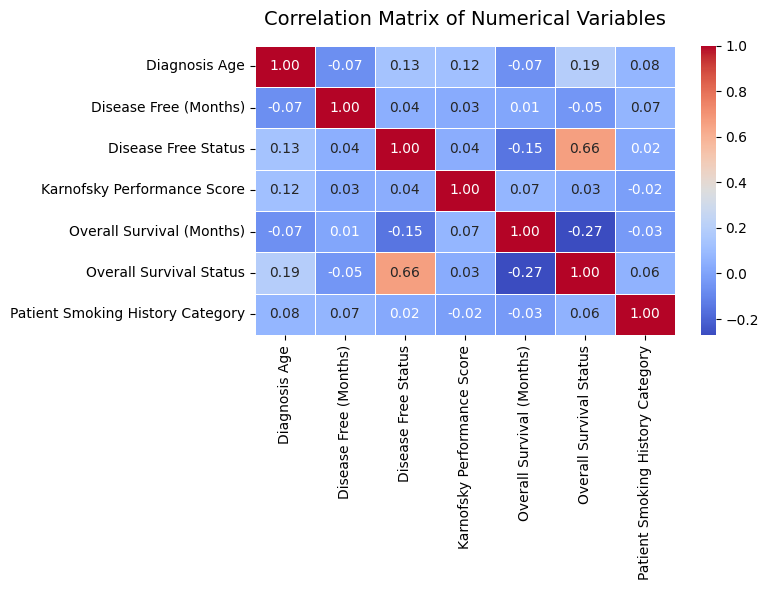

✅ Correlation matrix saved to /content/correlation_matrix.png


In [34]:
# Load dataset
df = second.copy()

# Automatically select numerical columns excluding 'Patient ID'
num_vars = df.select_dtypes(include=['number']).drop(columns=['Patient ID'], errors='ignore')

# Compute correlation matrix
corr_matrix = num_vars.corr()

# Plot
plt.figure(figsize=(8, 6))
plt.title("Correlation Matrix of Numerical Variables", fontsize=14, pad=15)  # Title placed above
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.tight_layout()
plt.savefig("/content/correlation_matrix.png")
plt.show()

print("✅ Correlation matrix saved to /content/correlation_matrix.png")


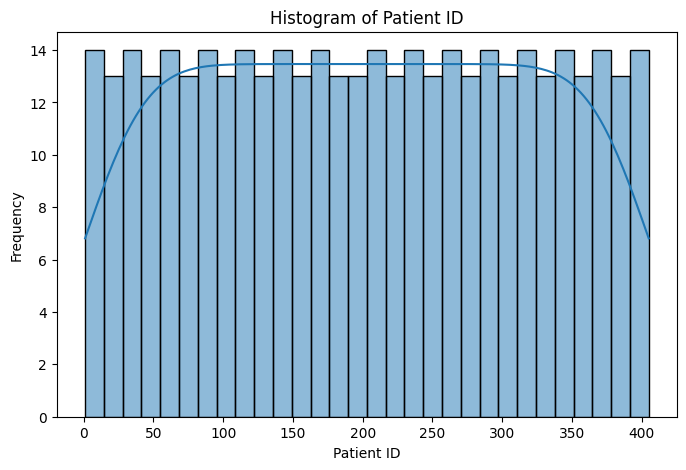

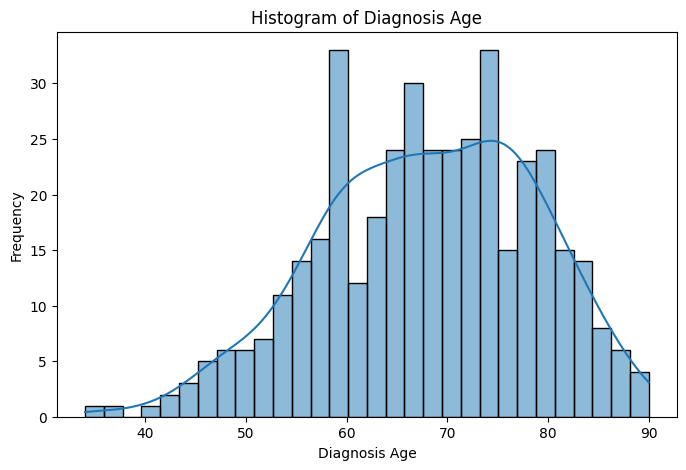

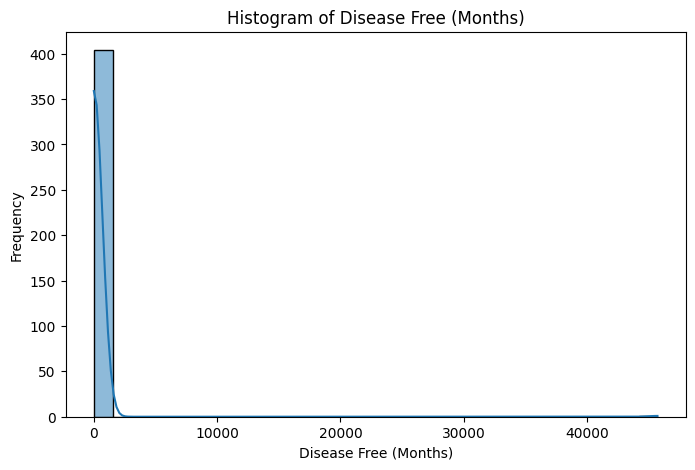

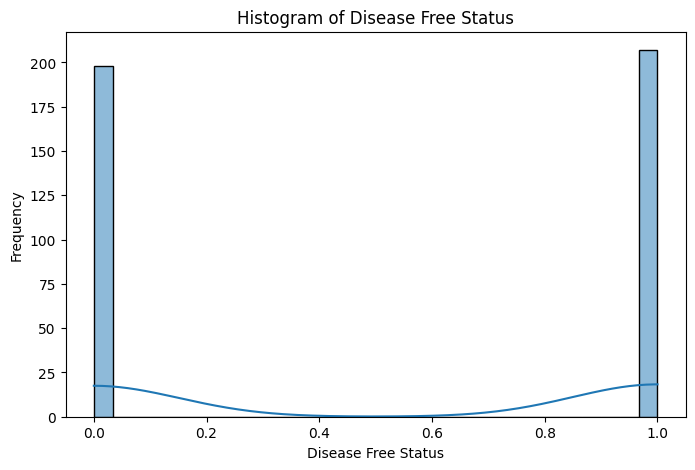

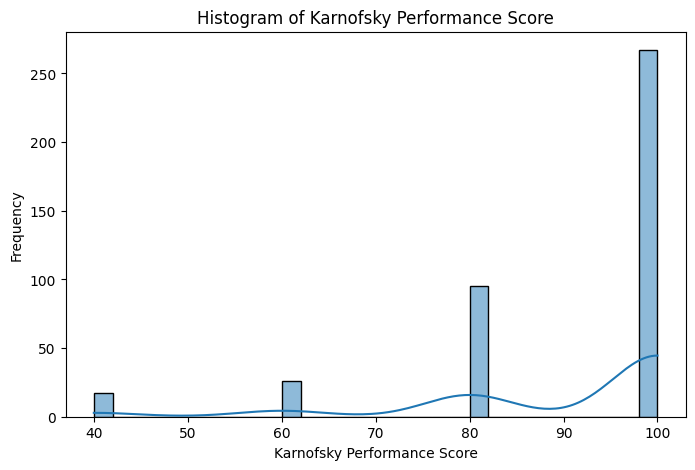

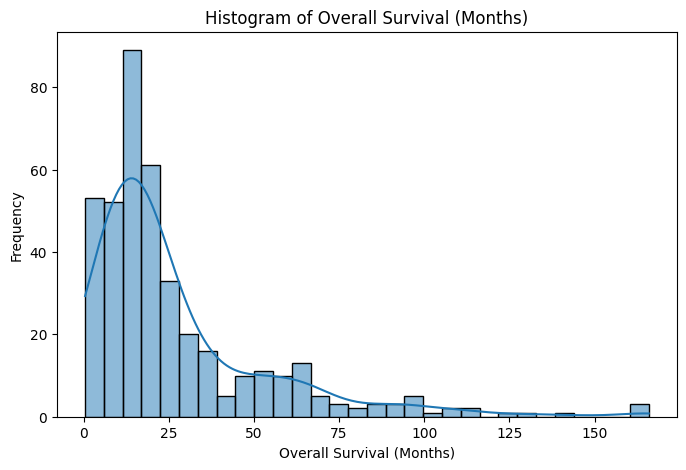

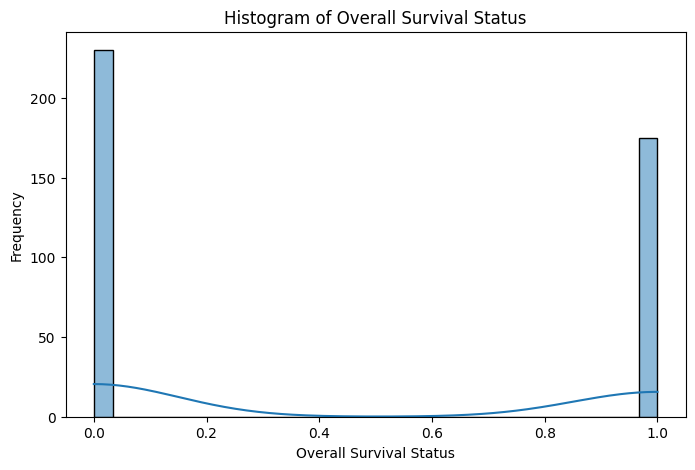

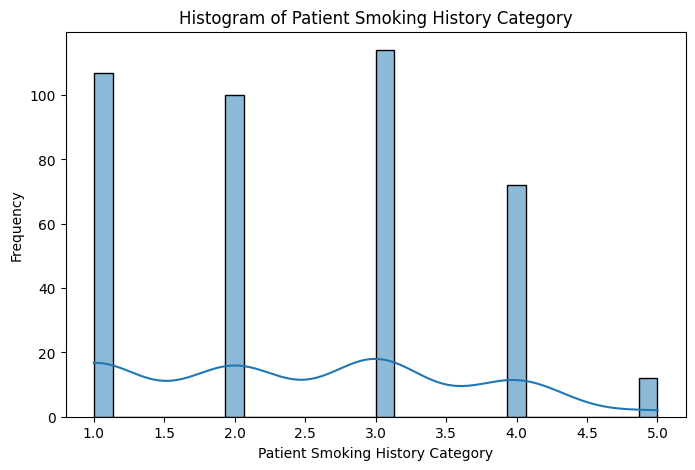

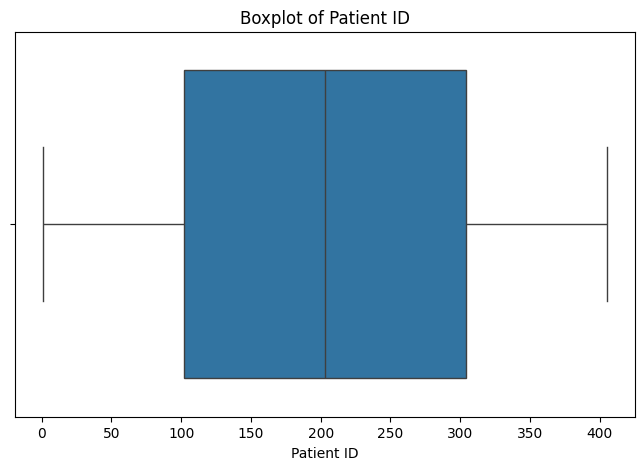

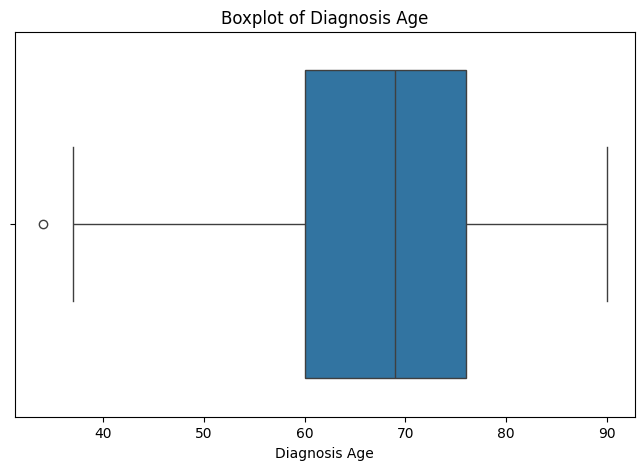

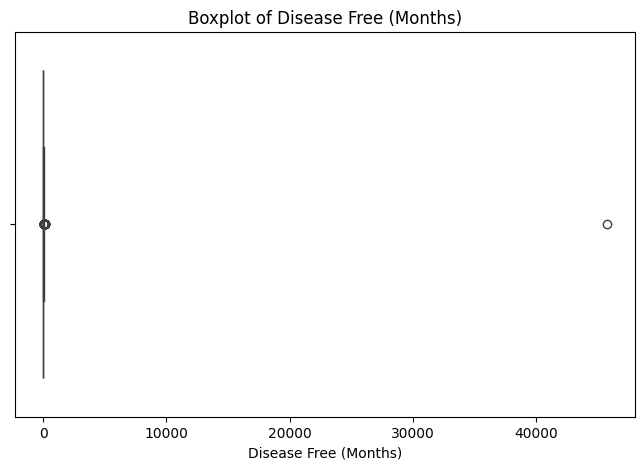

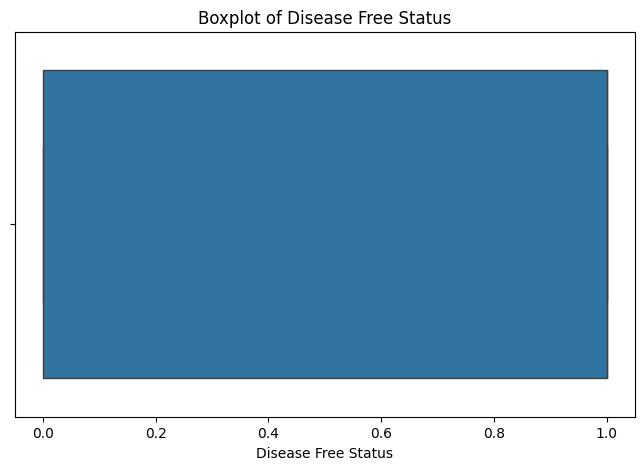

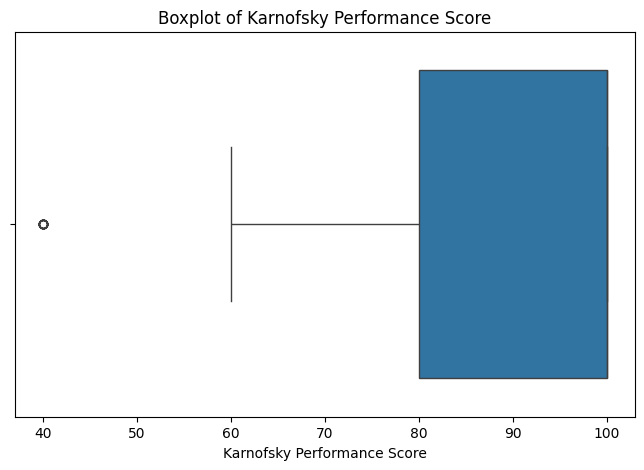

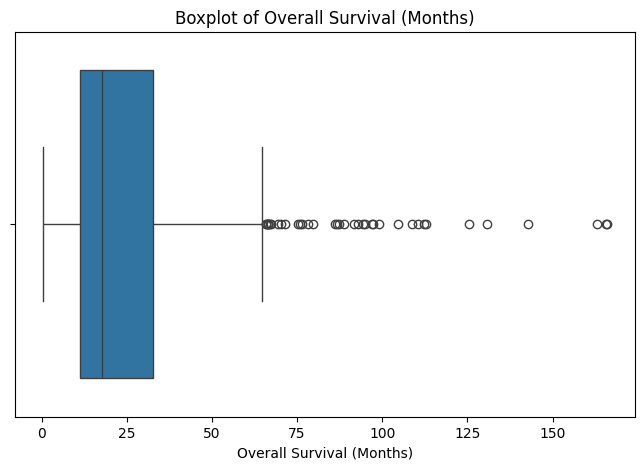

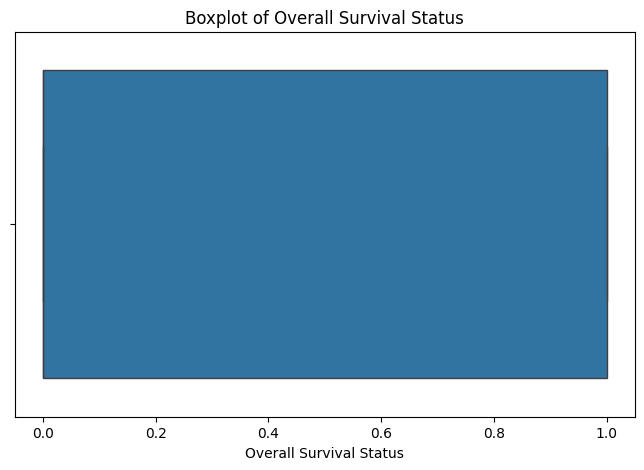

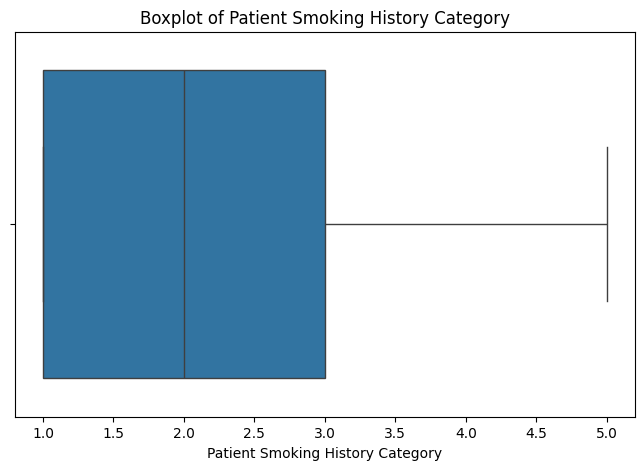

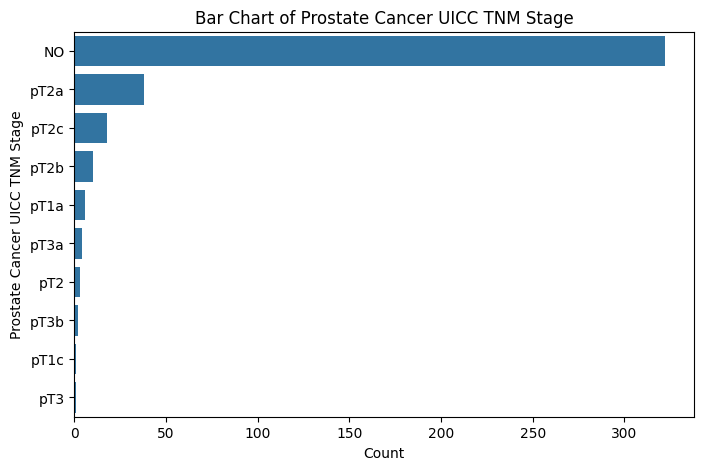

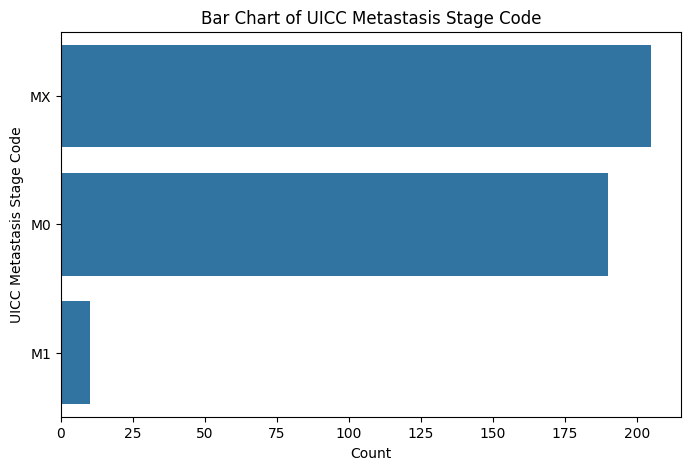

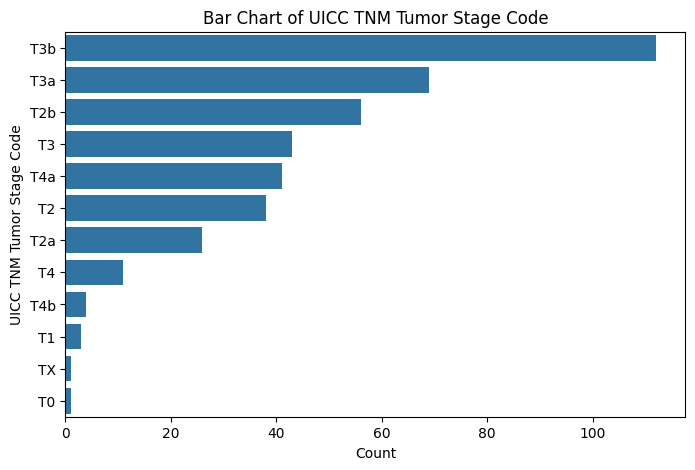

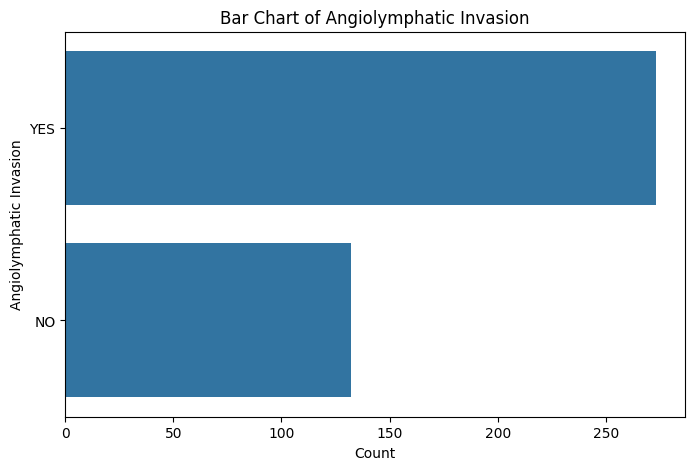

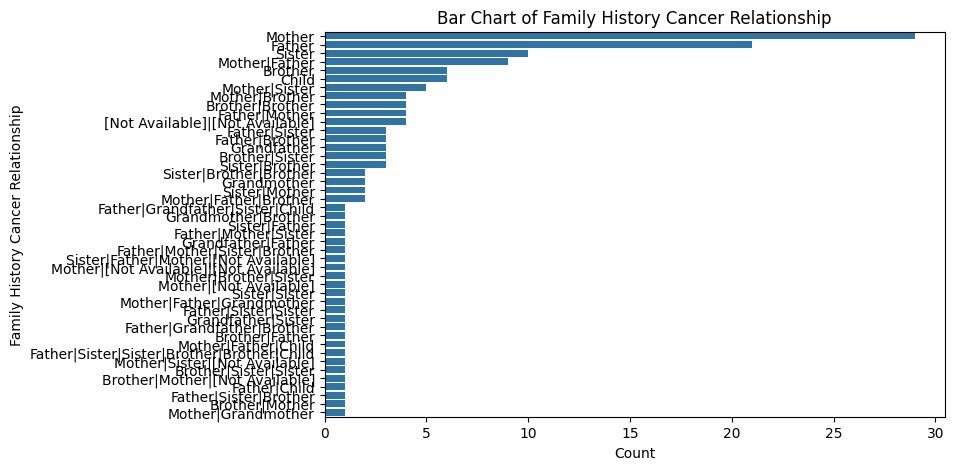

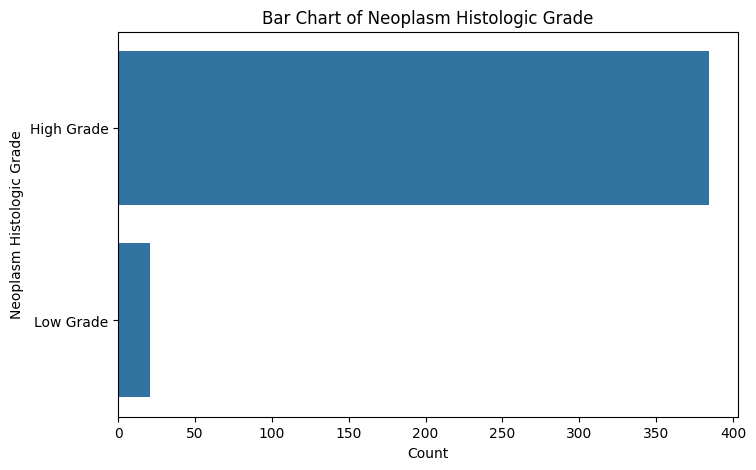

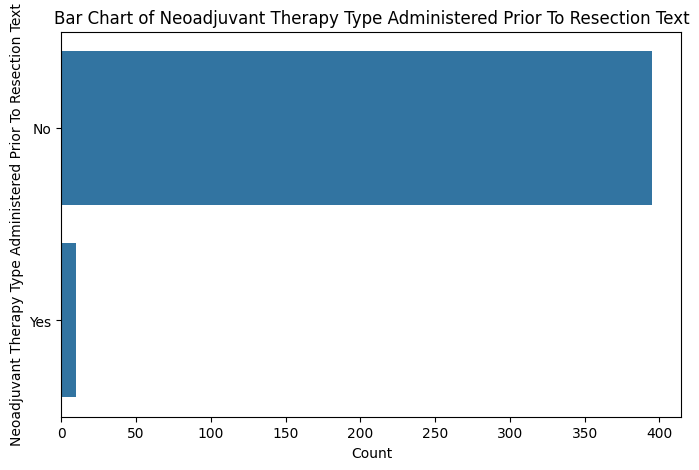

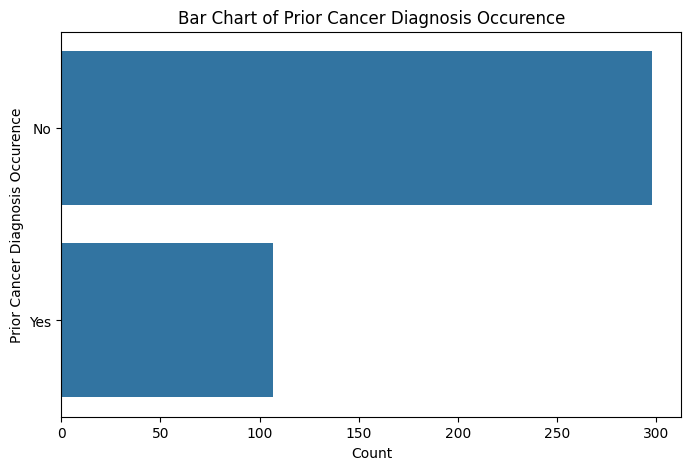

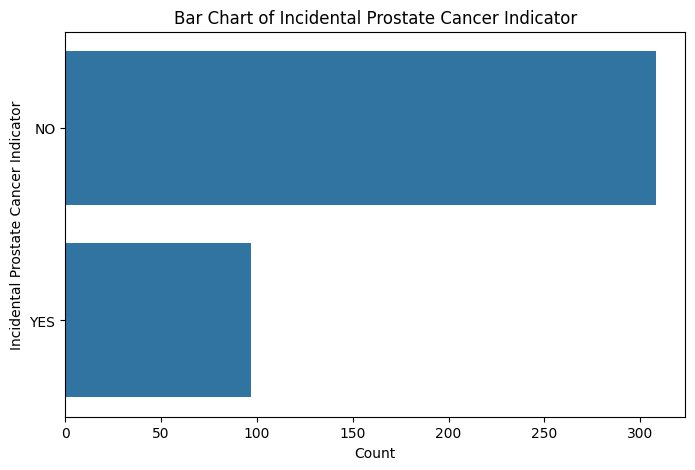

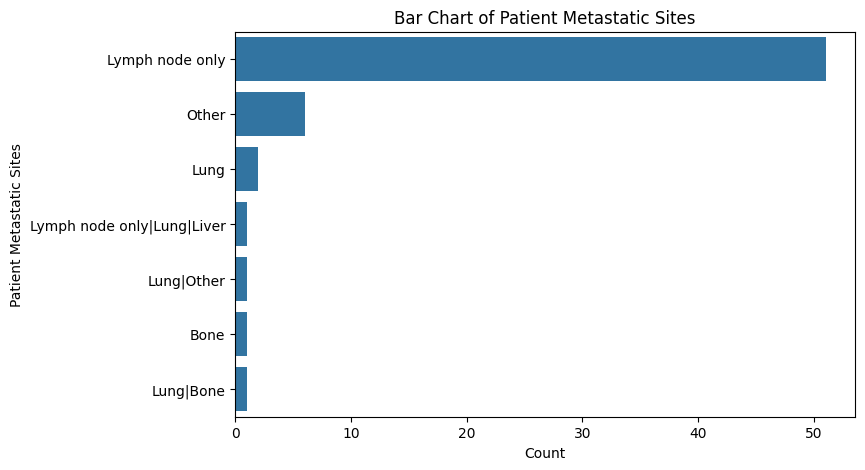

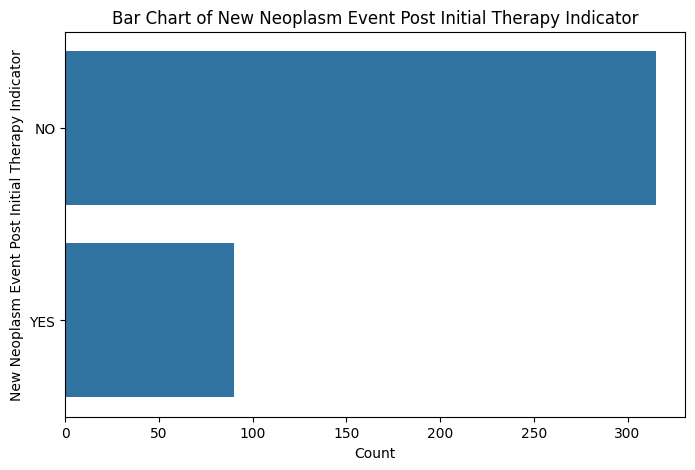

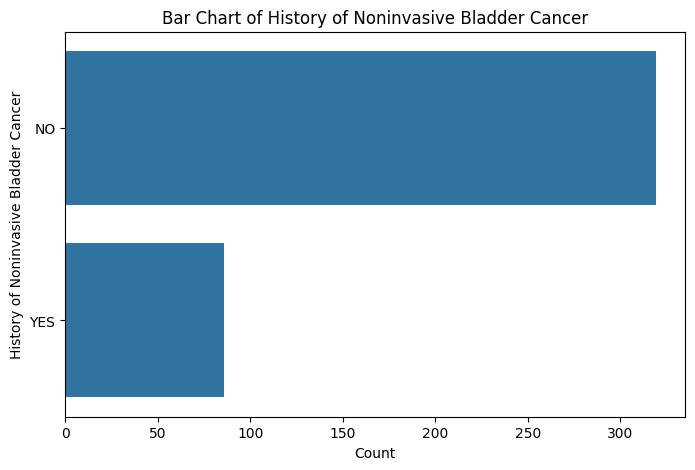

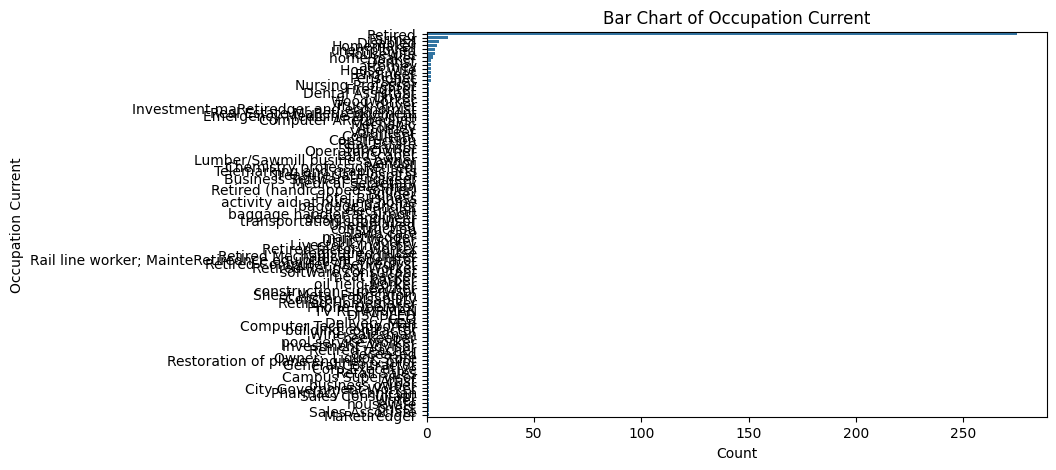

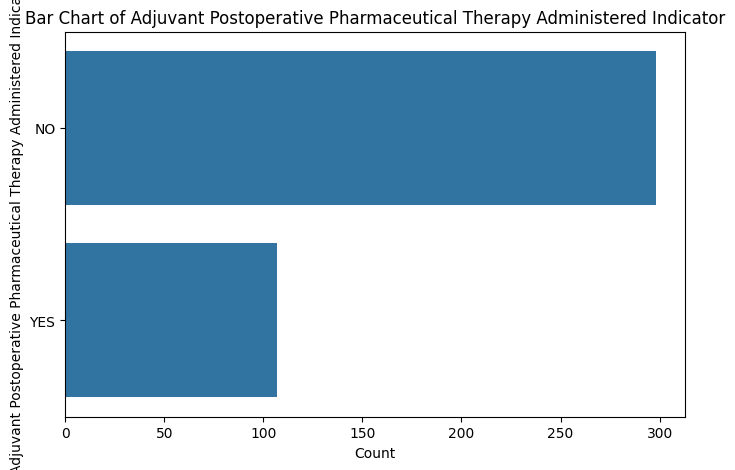

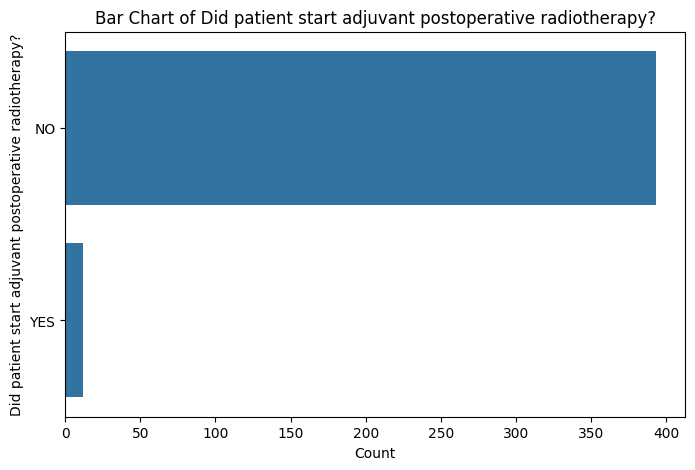

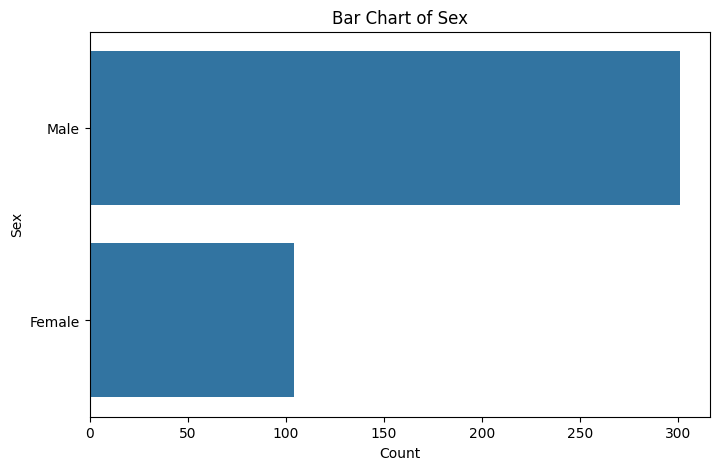

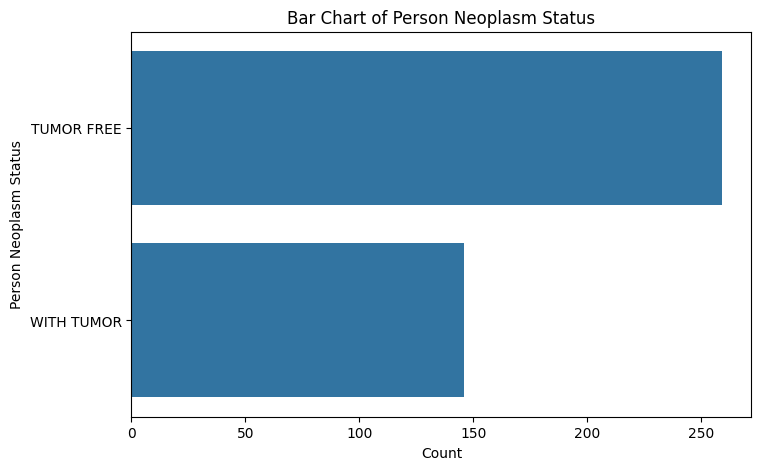

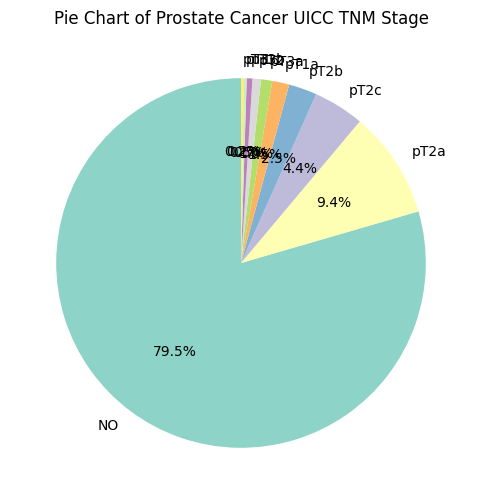

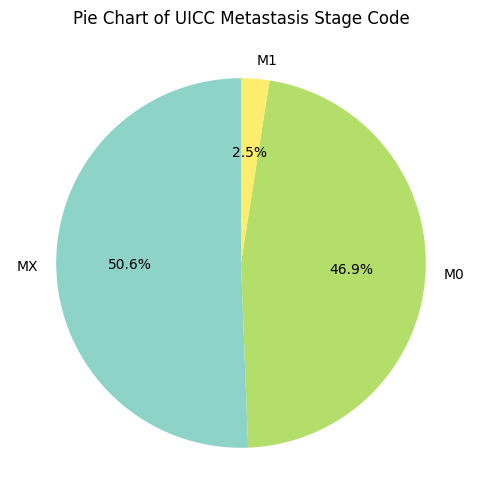

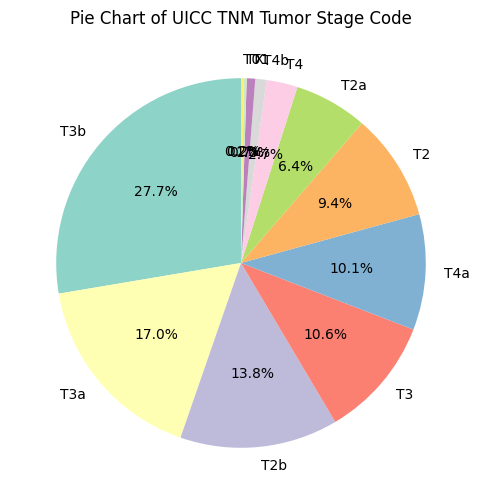

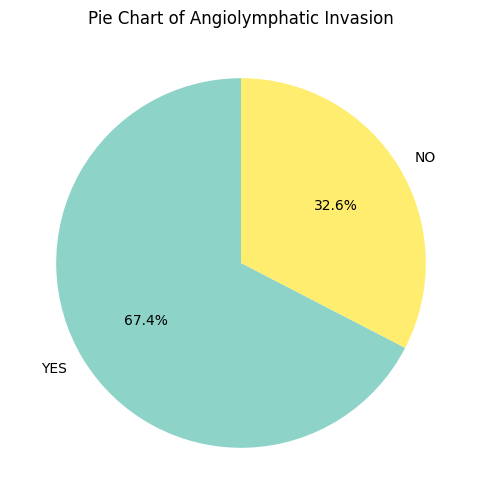

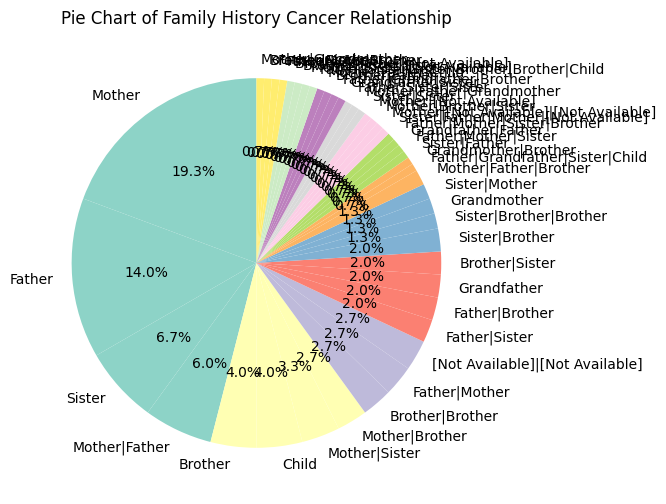

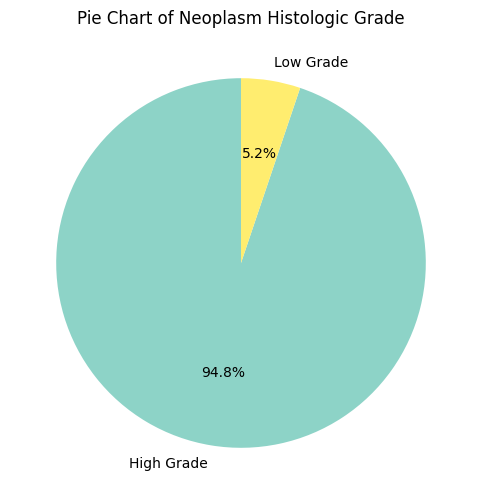

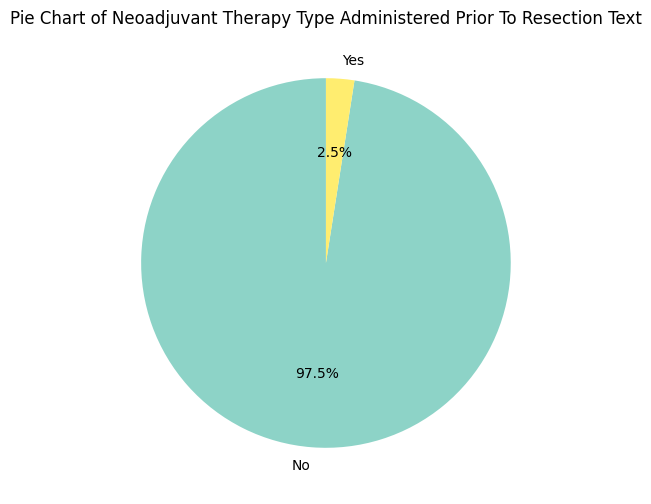

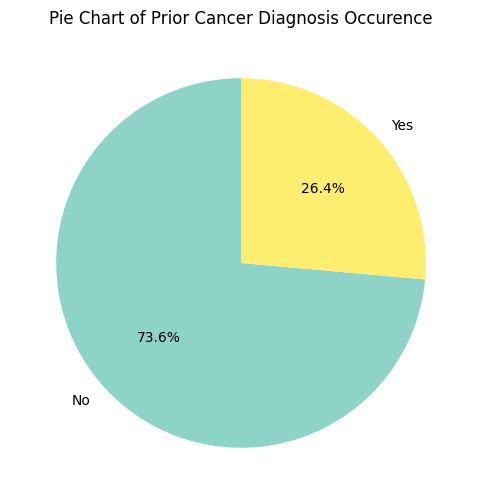

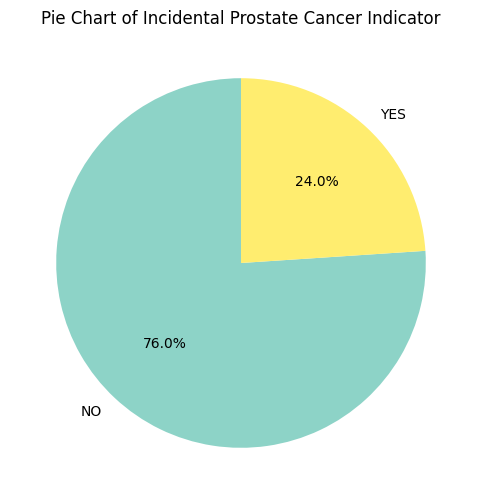

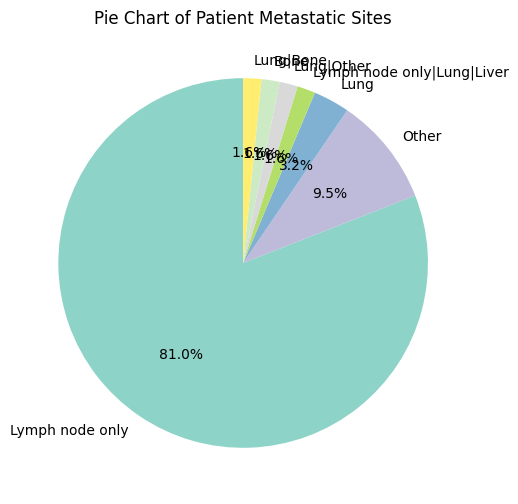

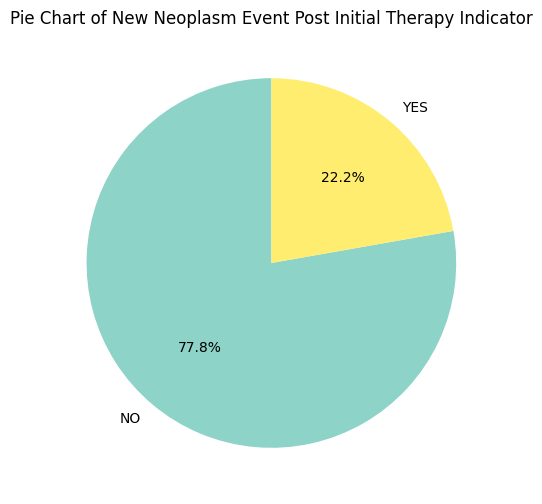

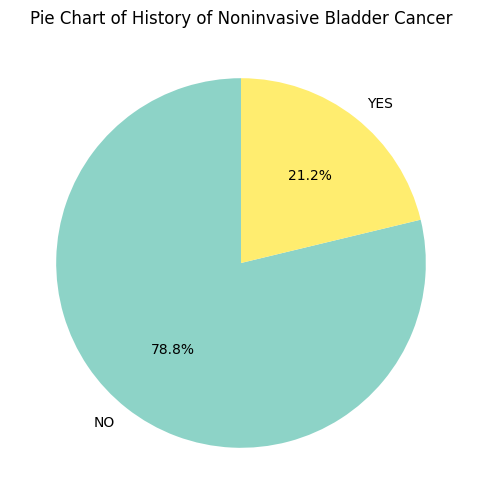

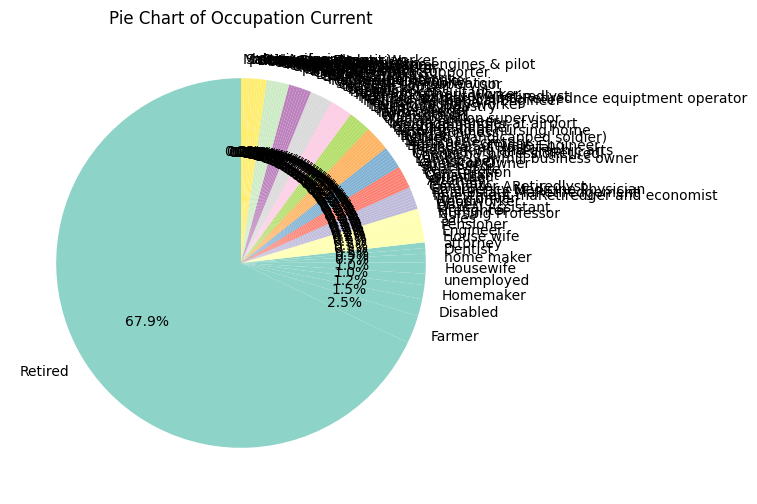

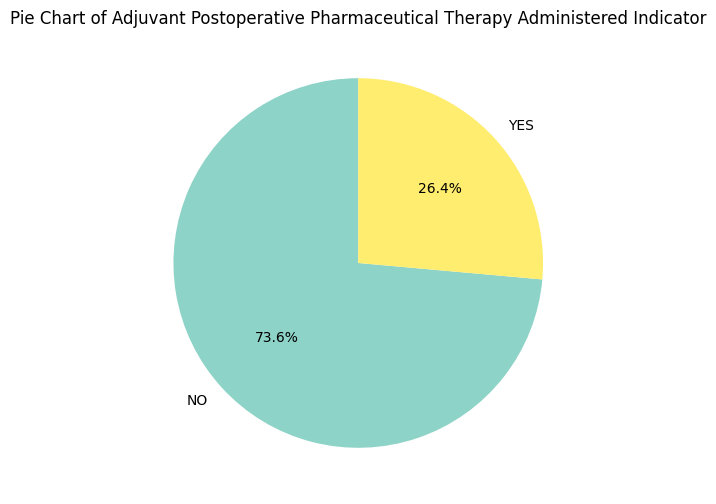

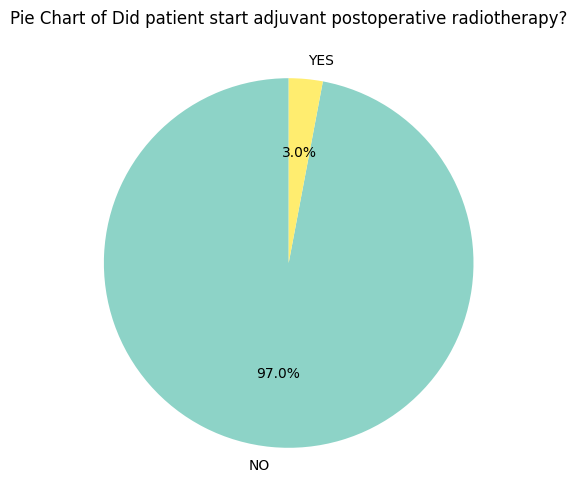

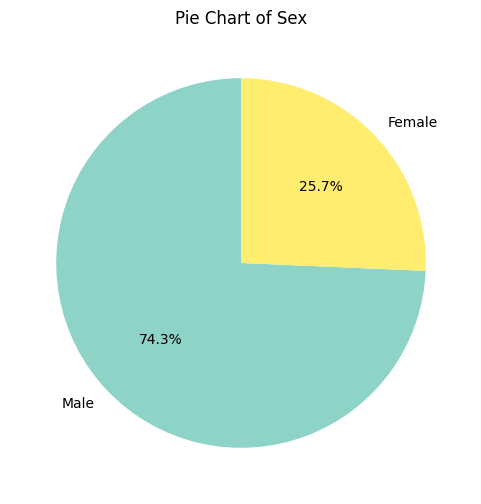

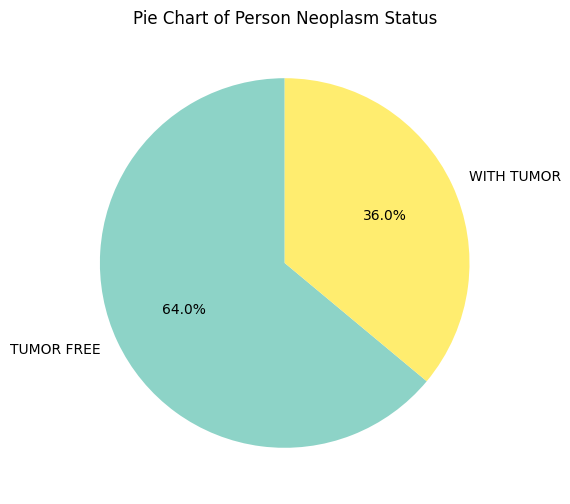

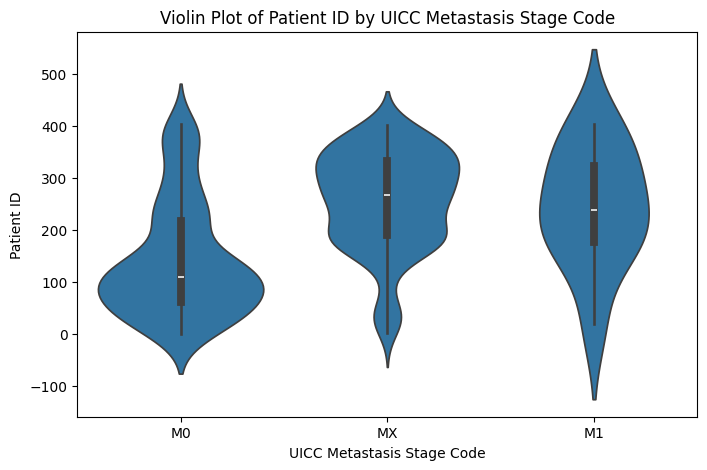

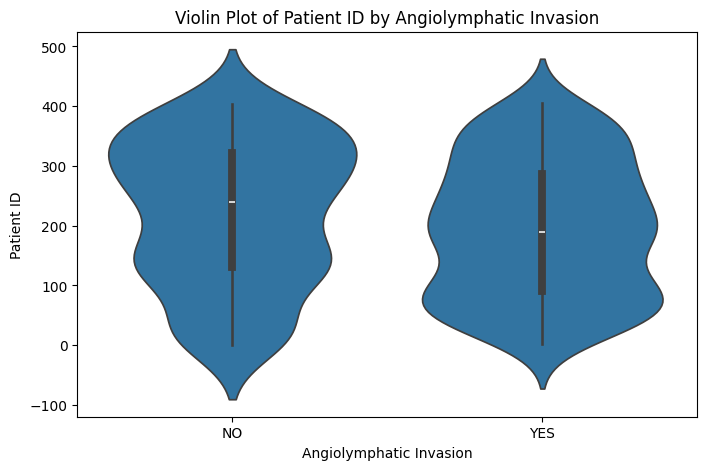

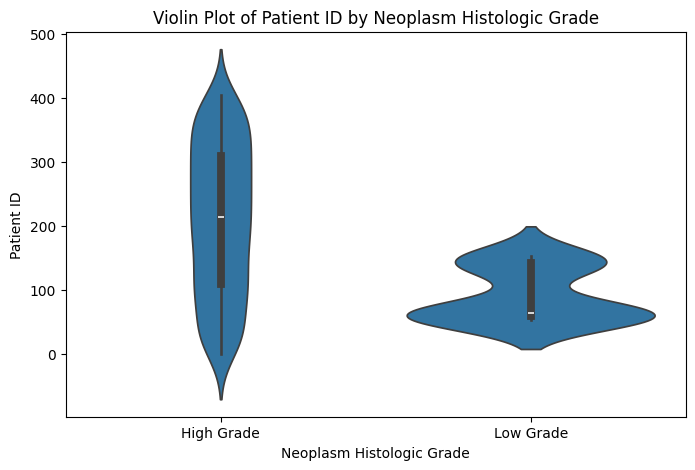

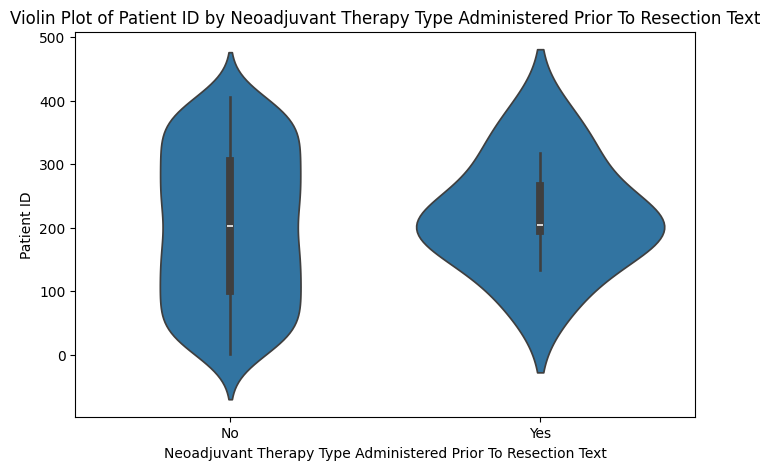

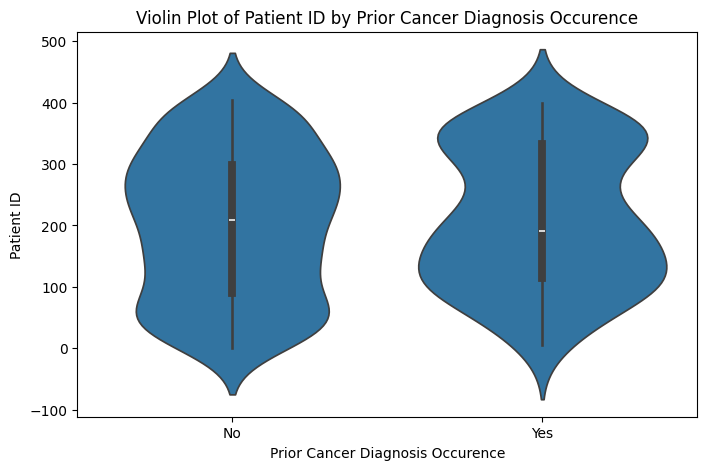

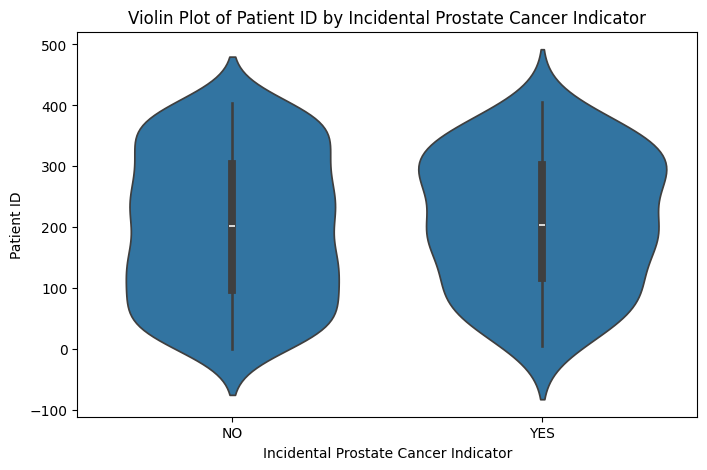

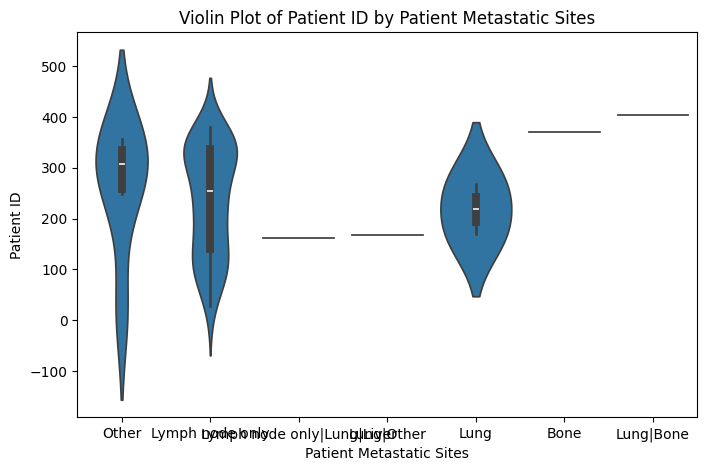

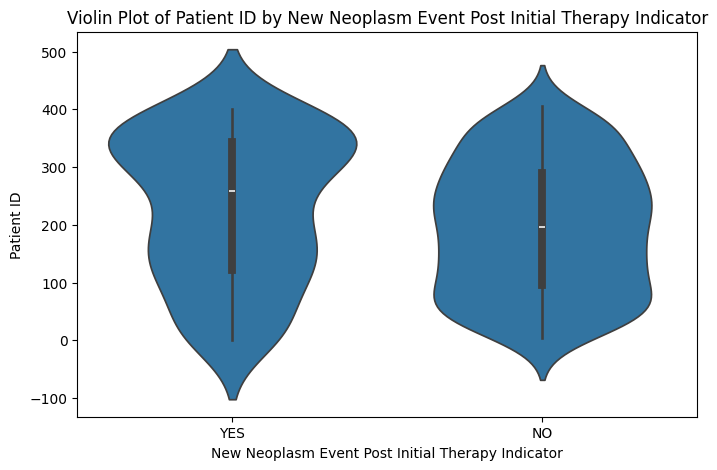

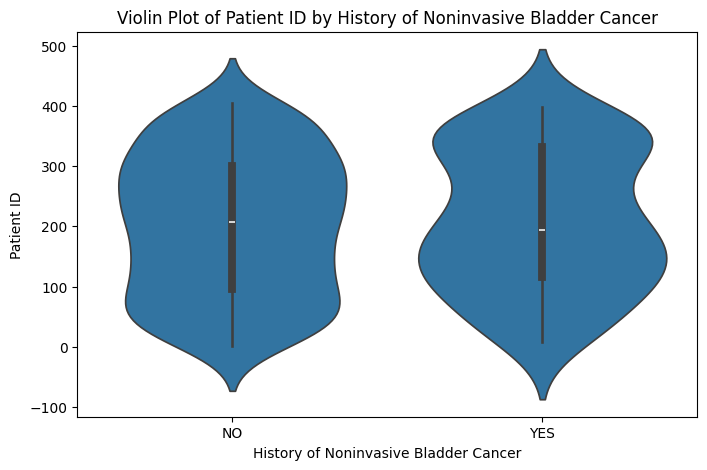

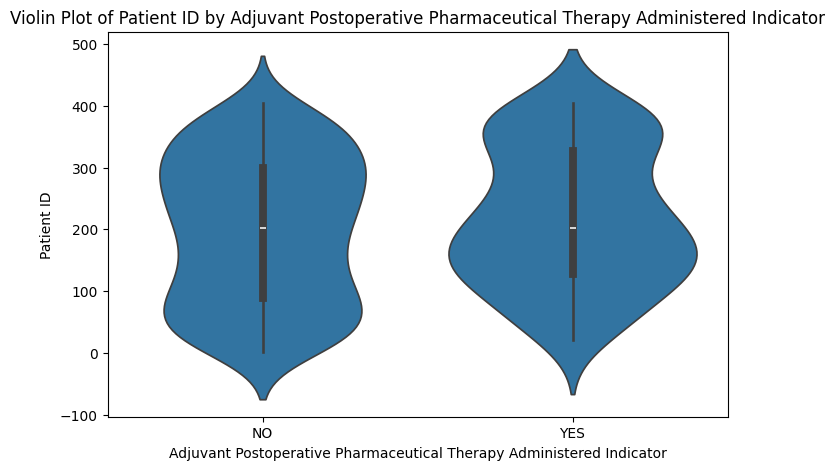

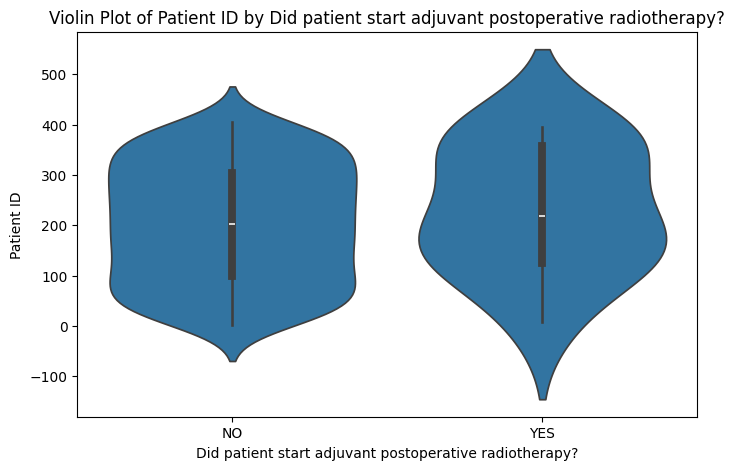

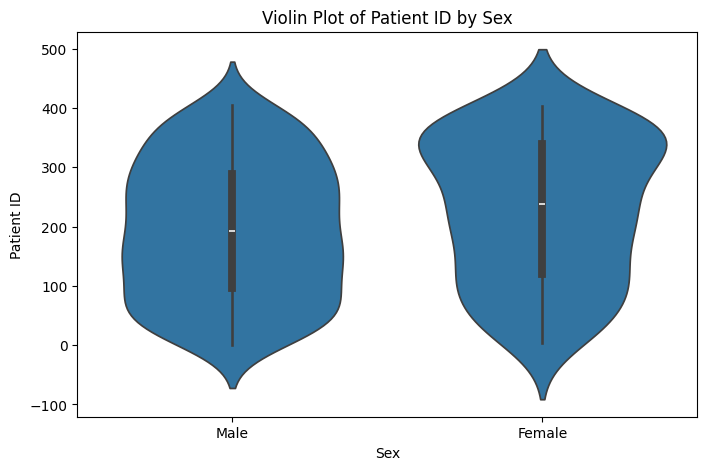

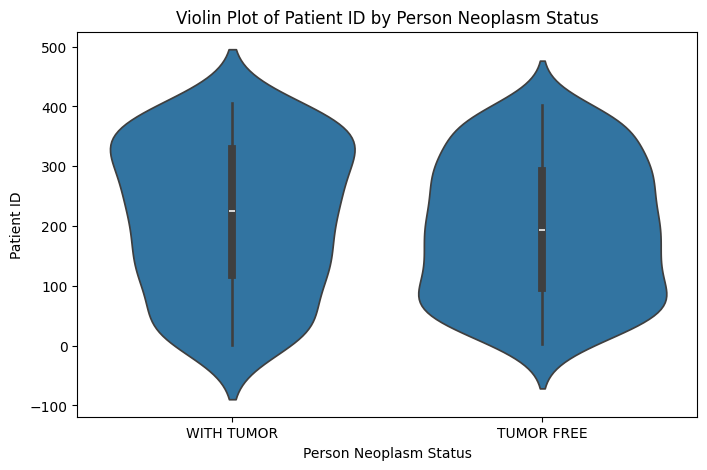

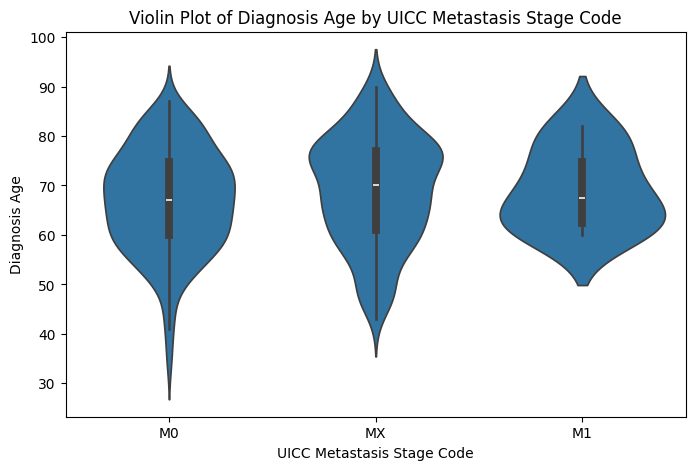

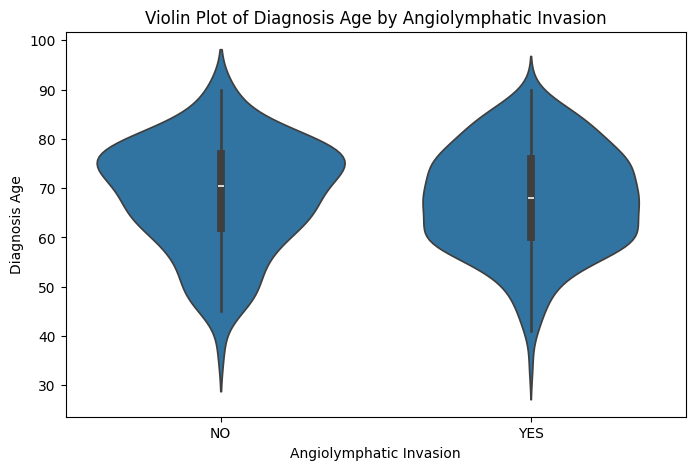

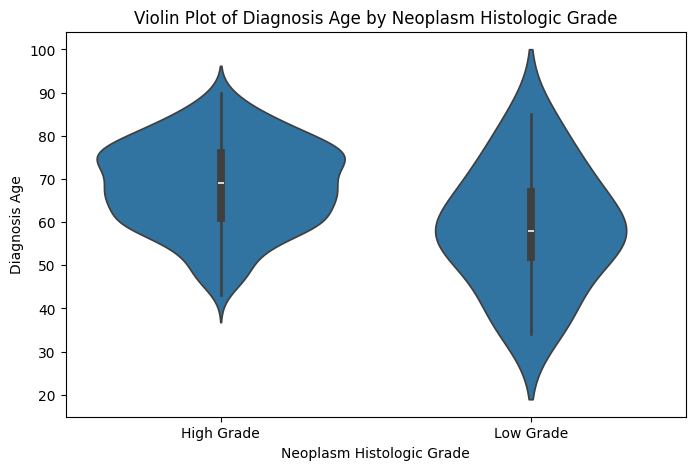

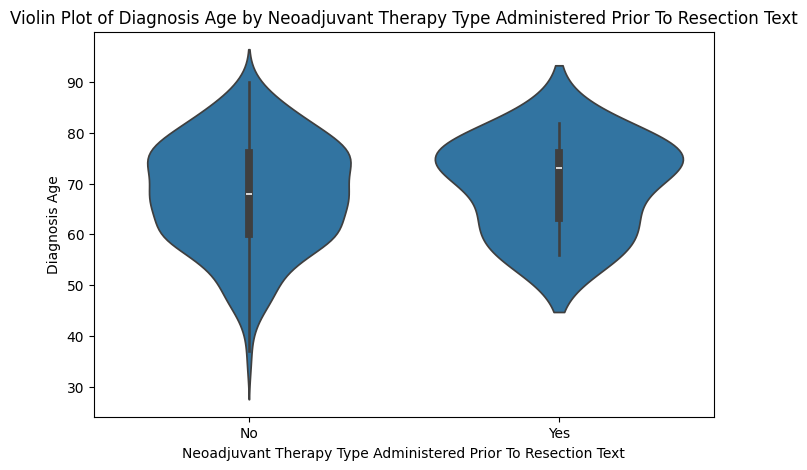

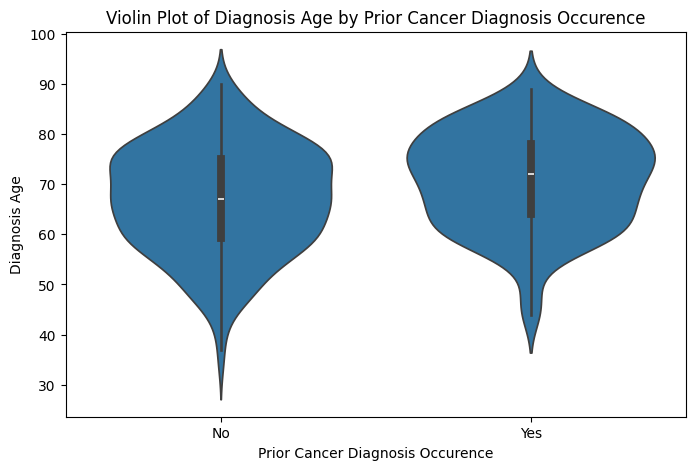

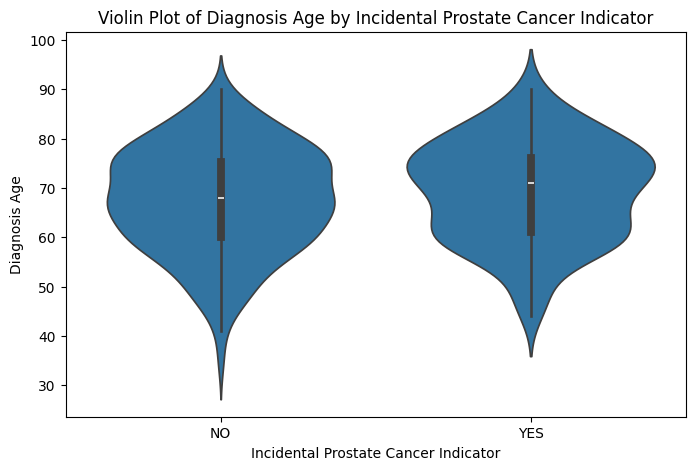

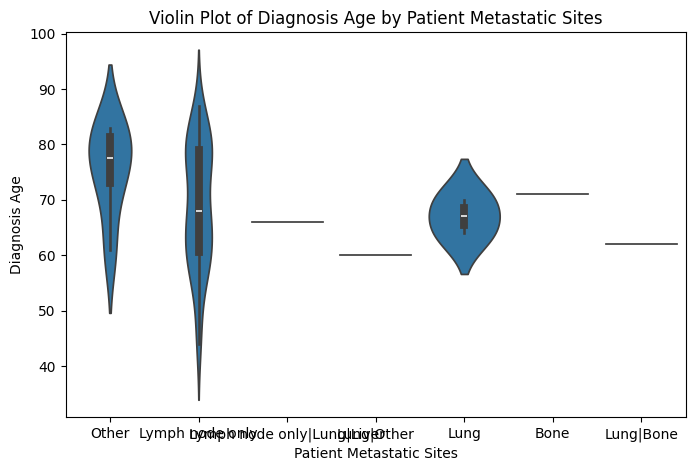

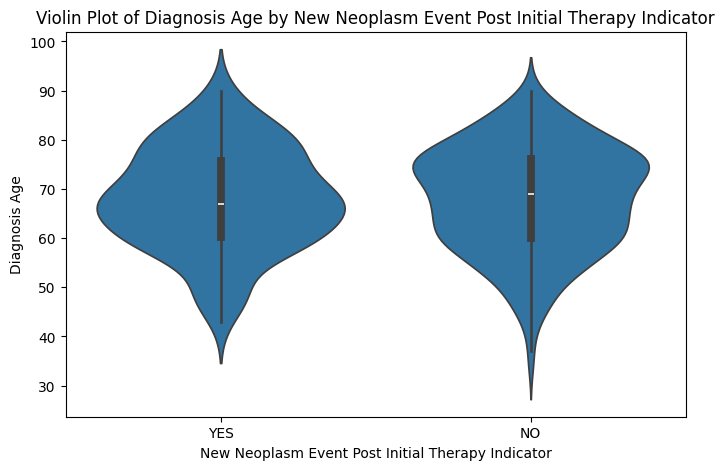

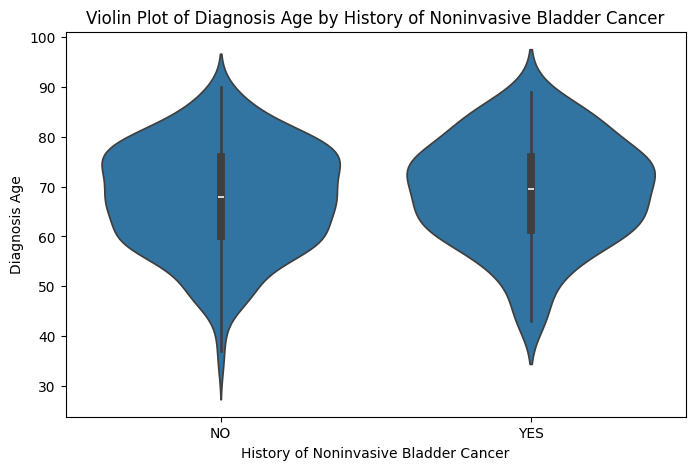

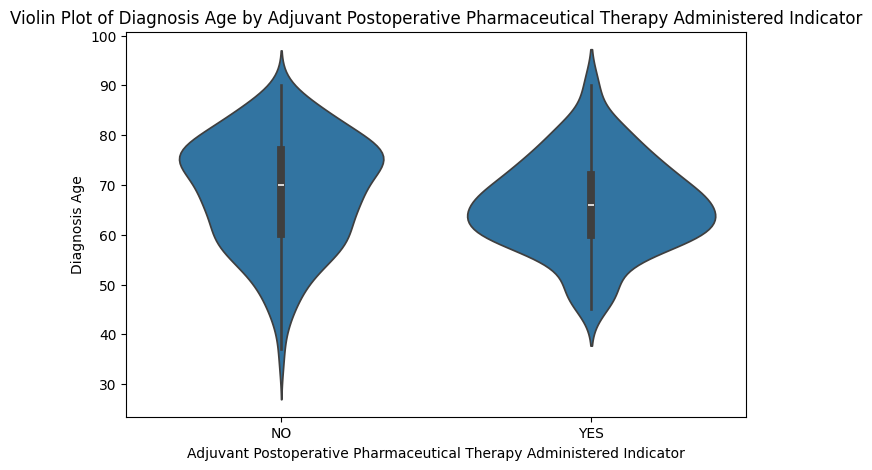

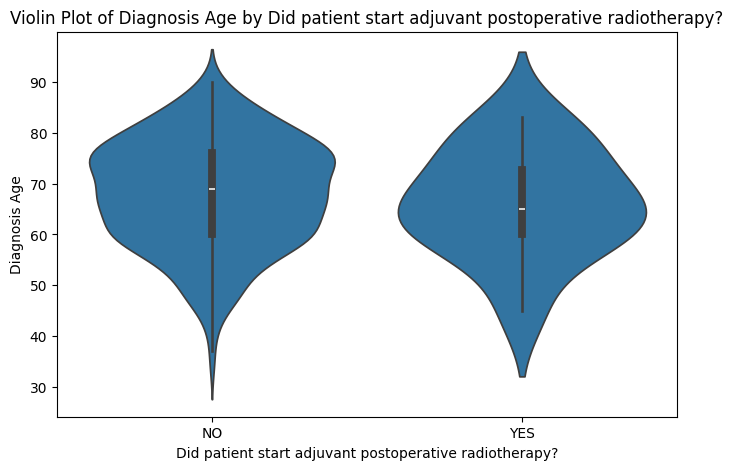

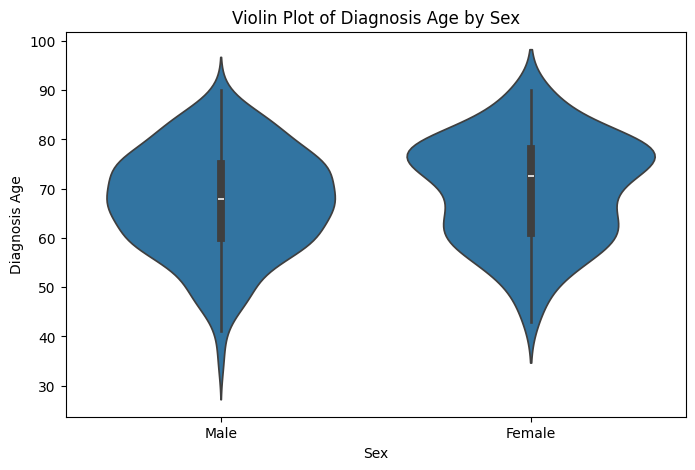

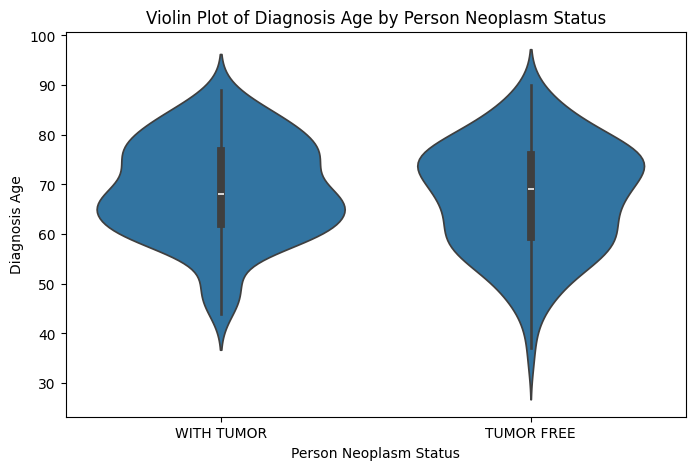

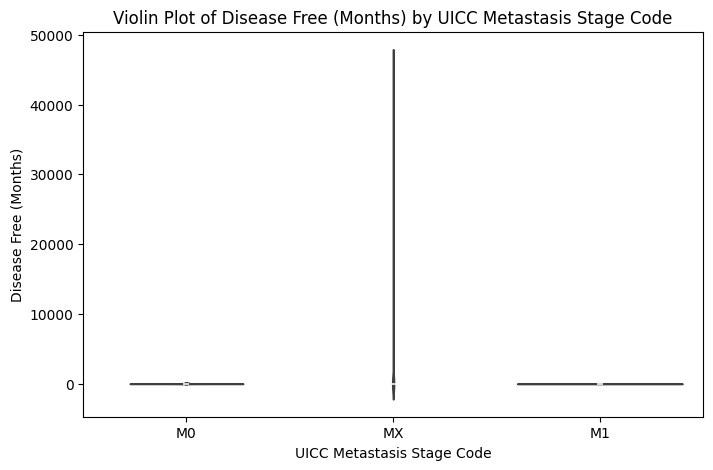

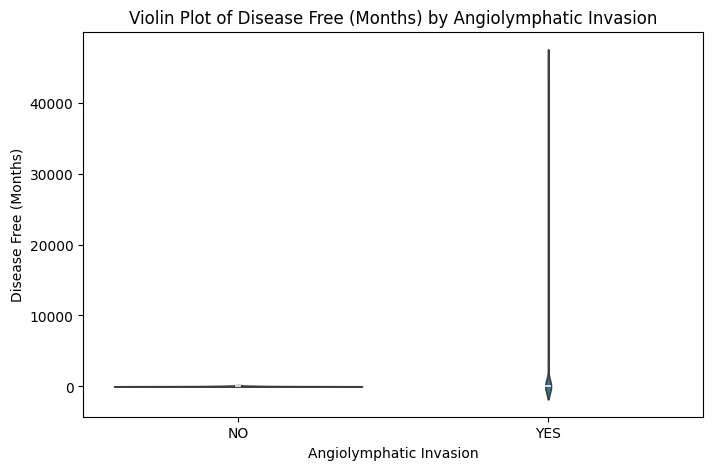

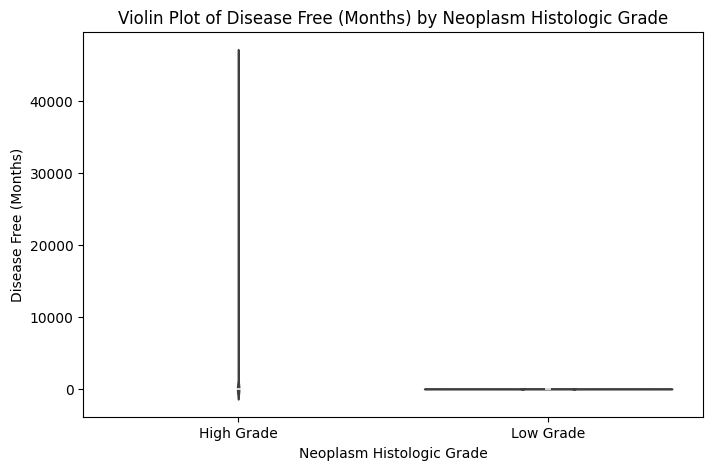

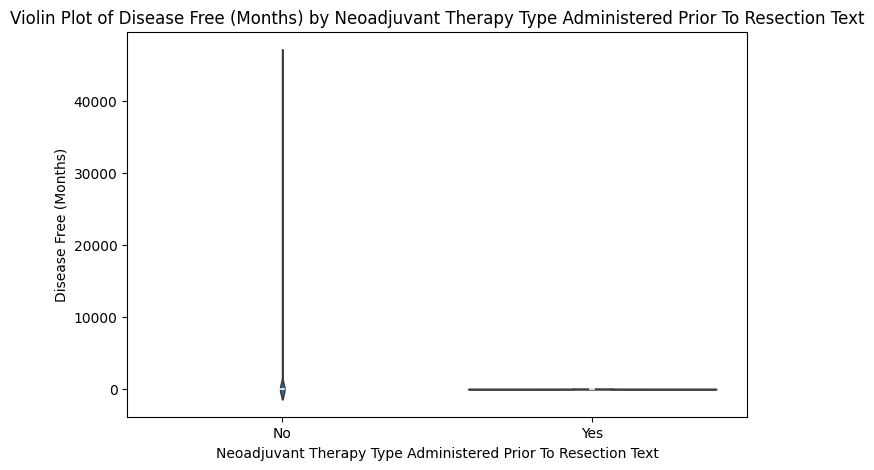

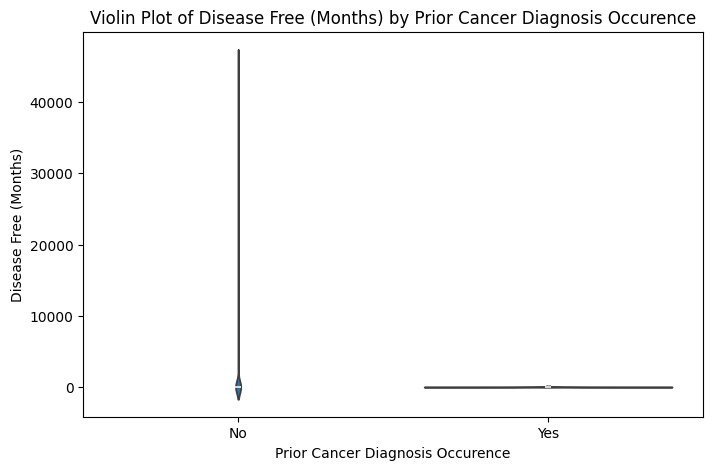

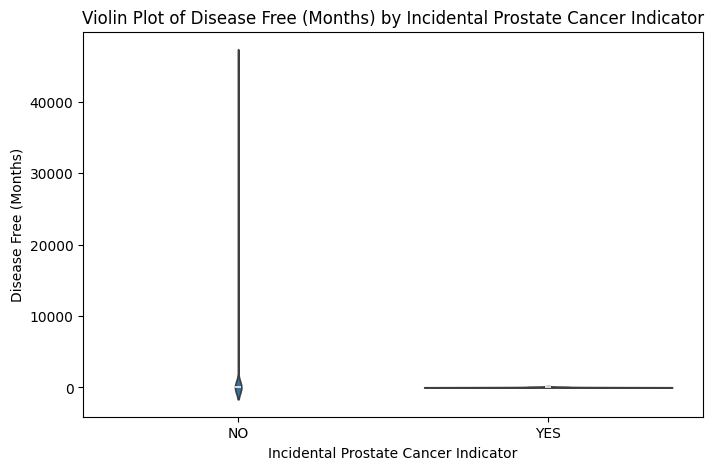

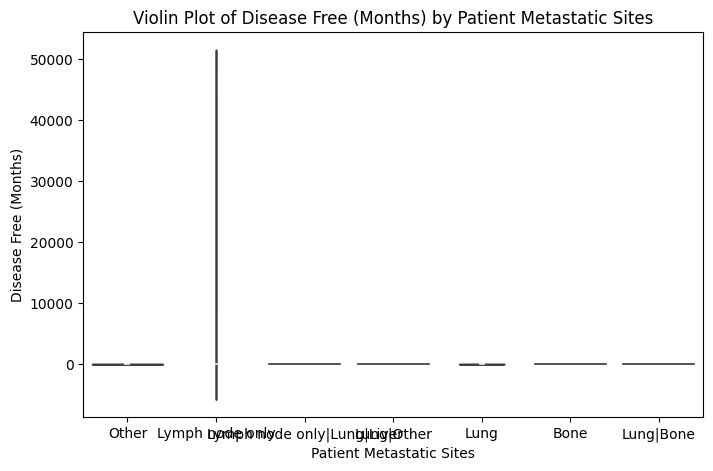

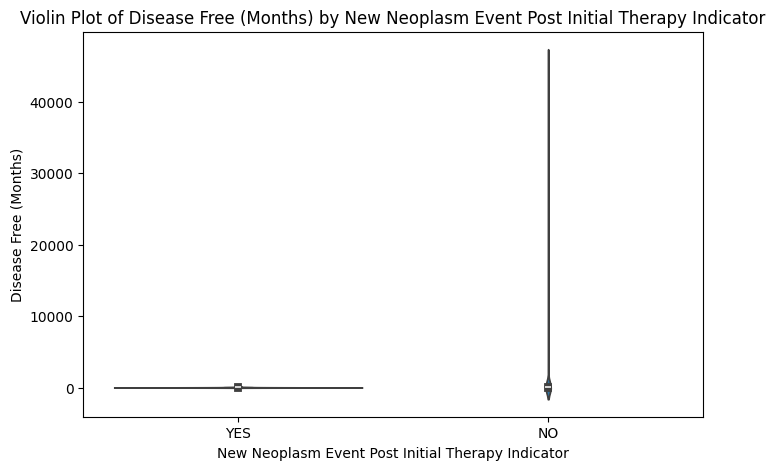

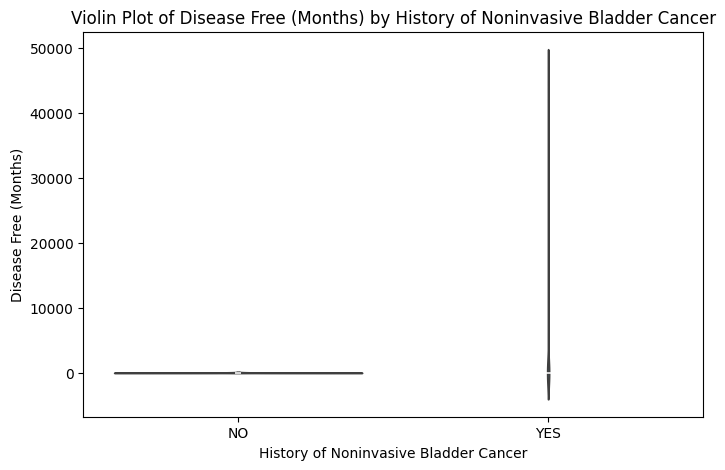

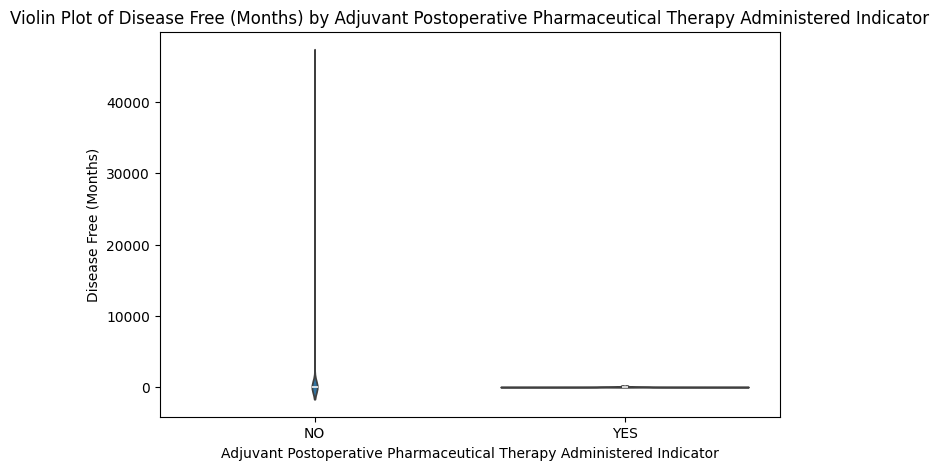

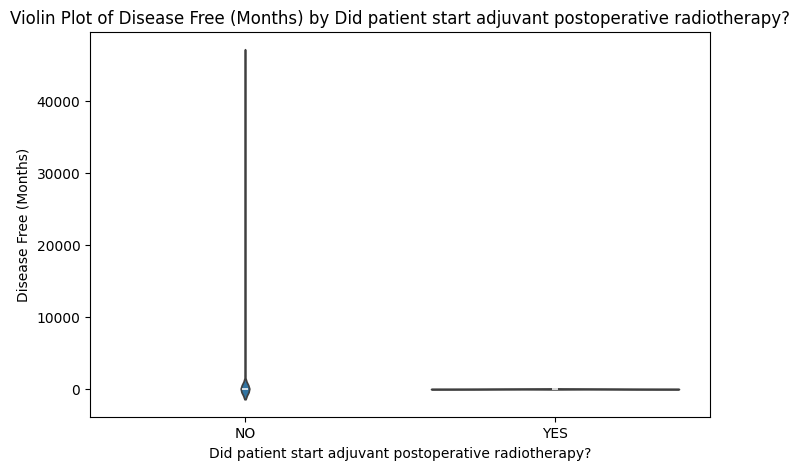

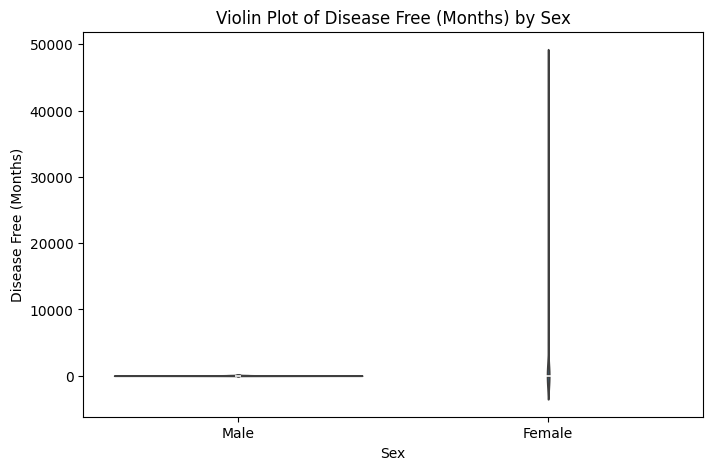

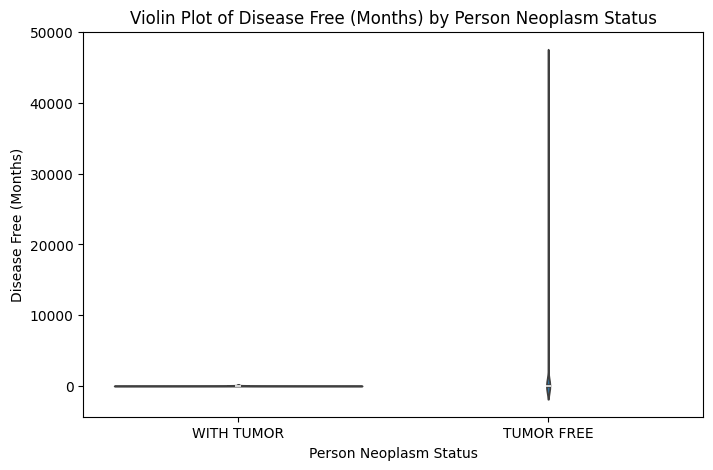

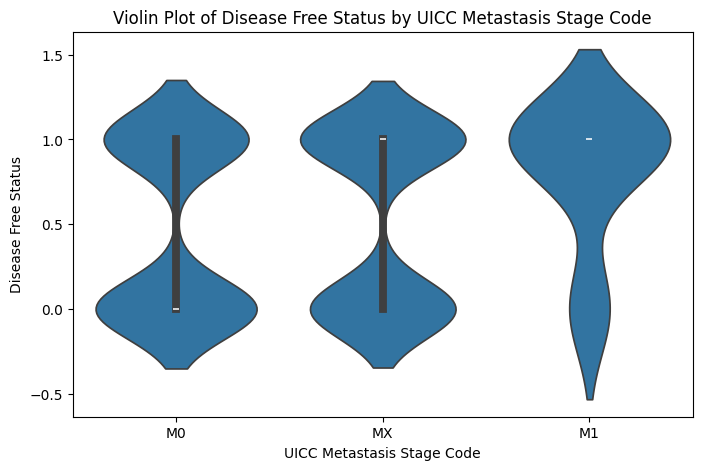

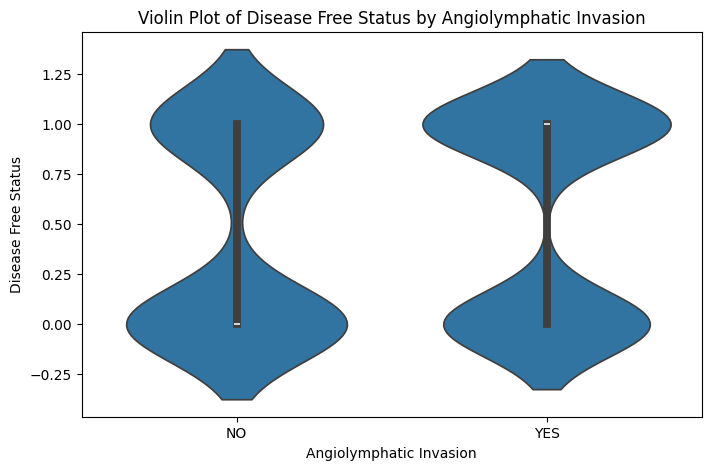

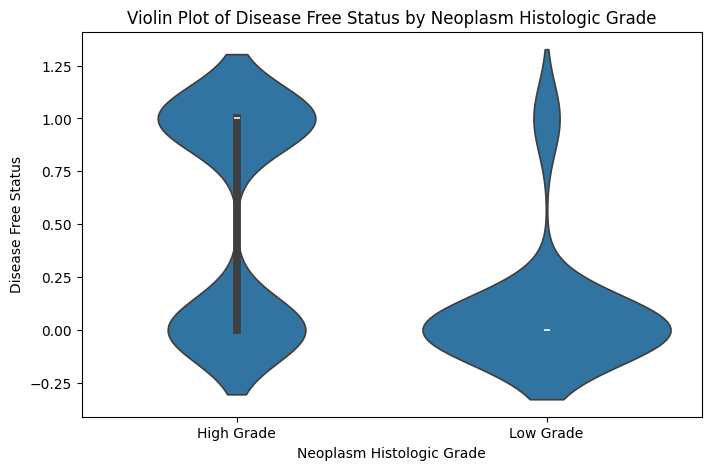

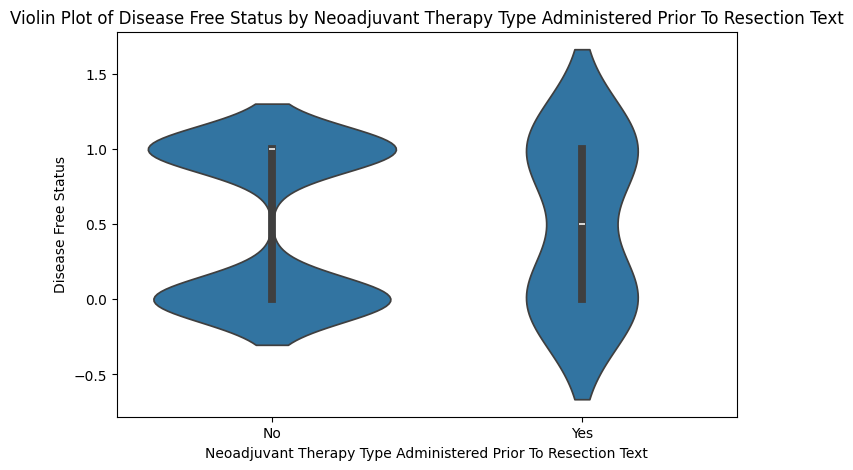

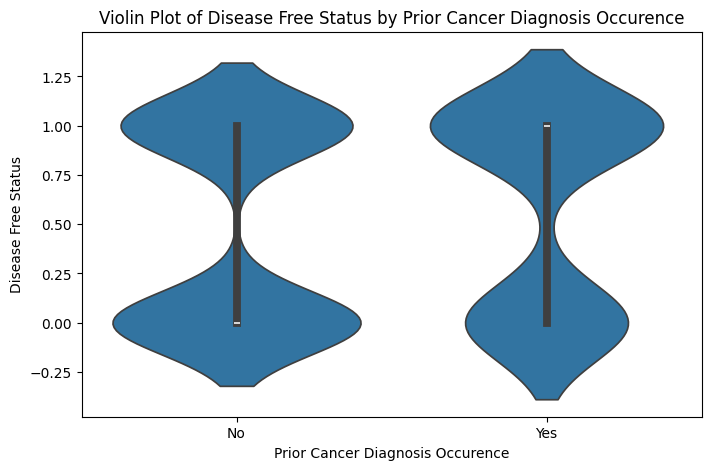

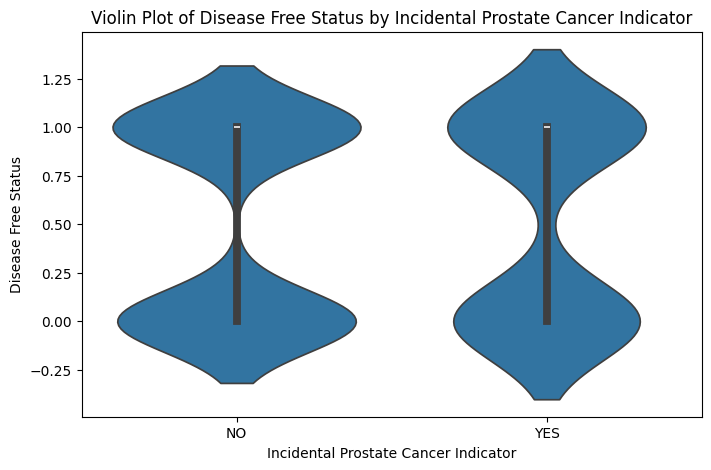

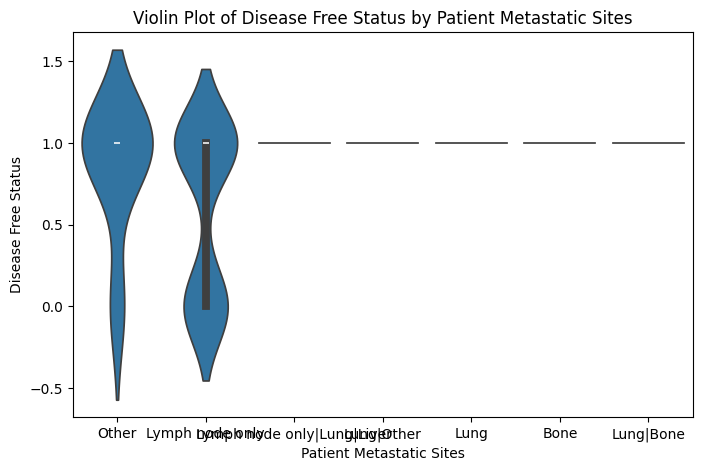

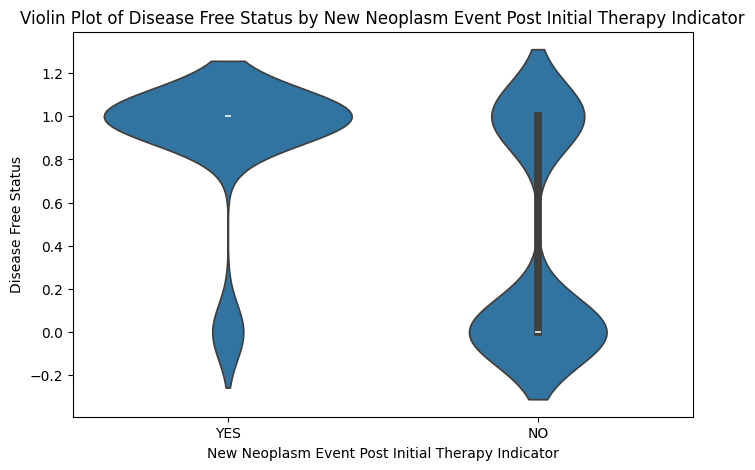

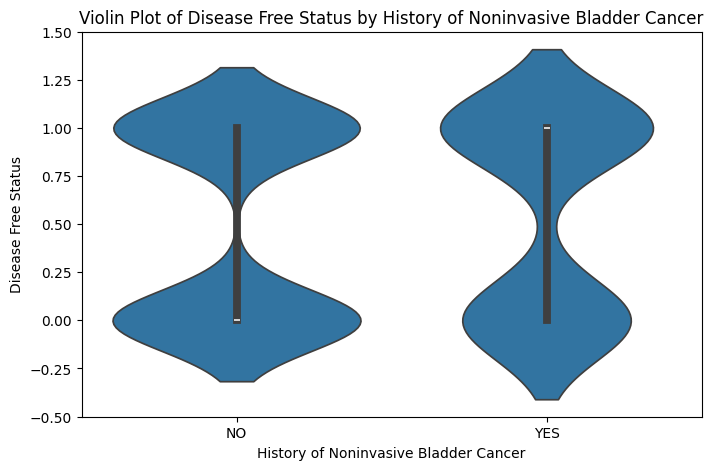

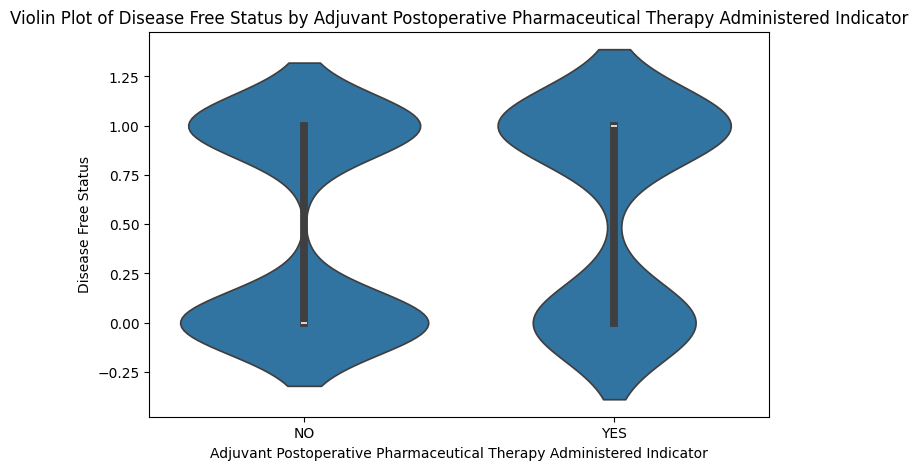

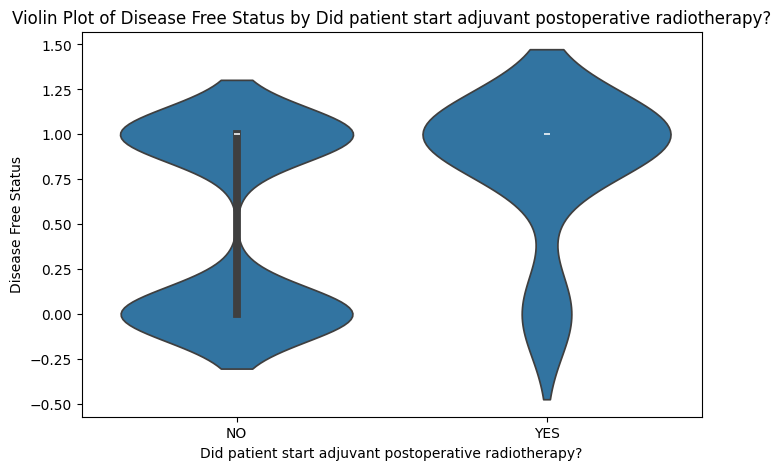

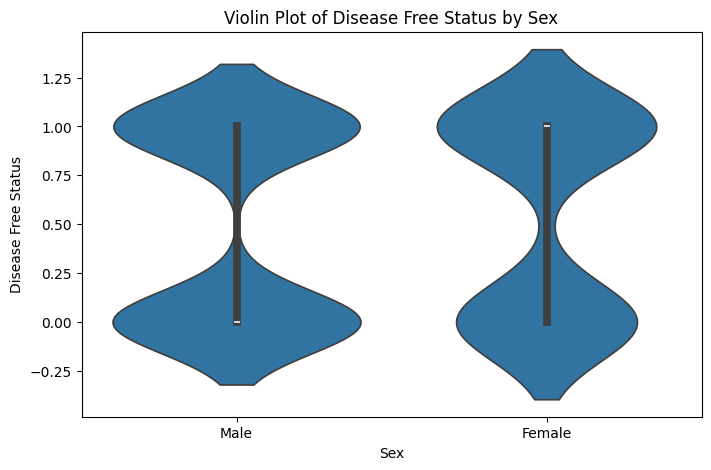

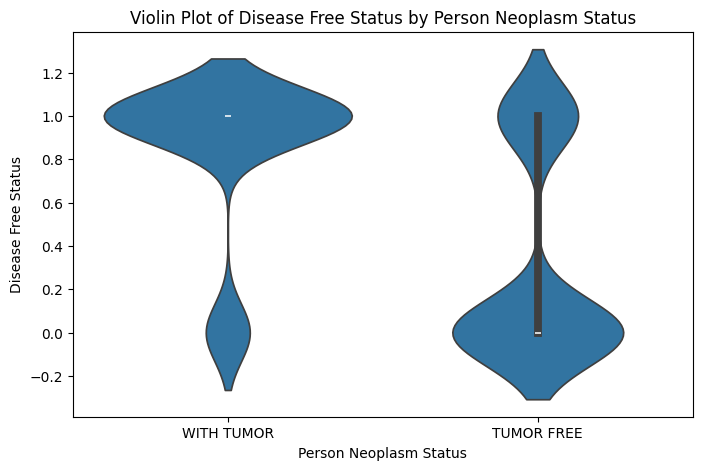

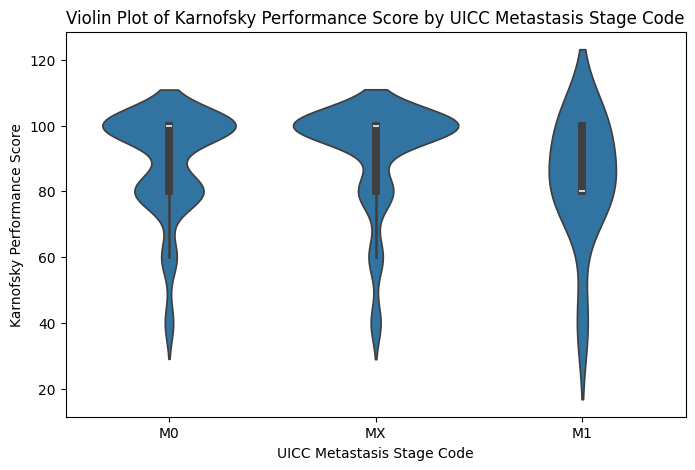

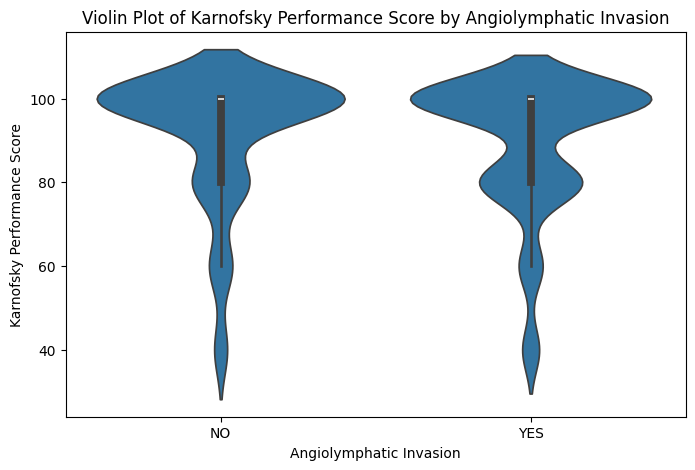

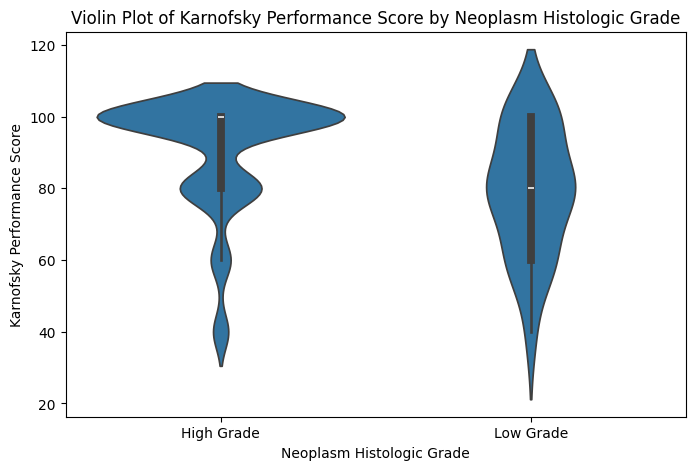

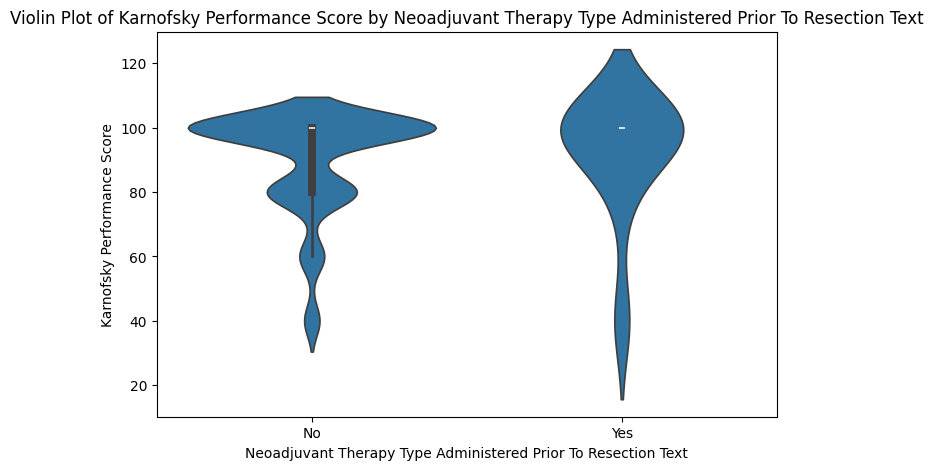

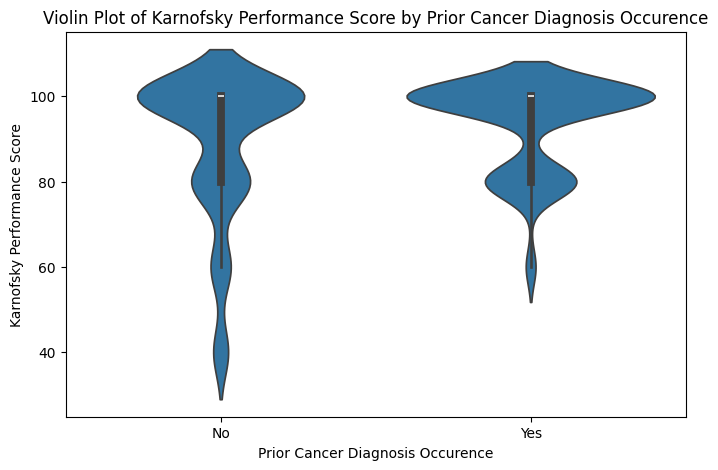

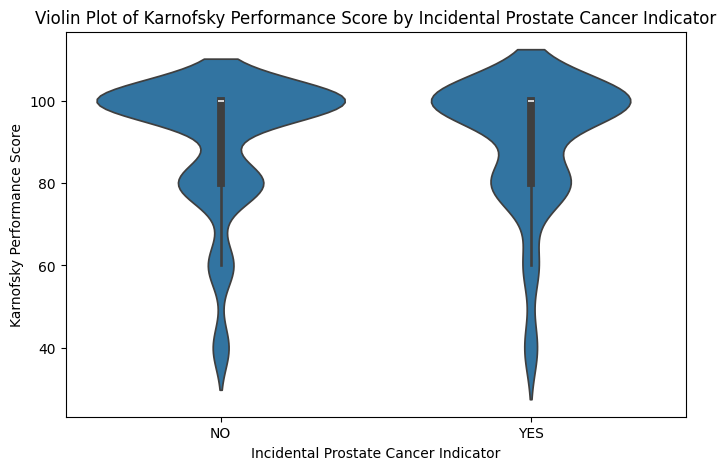

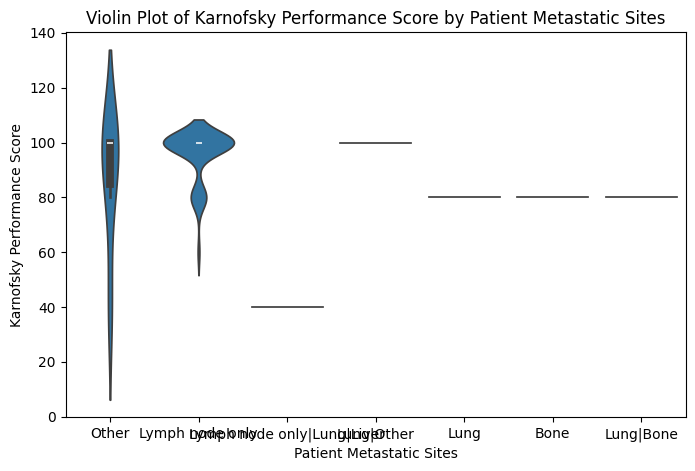

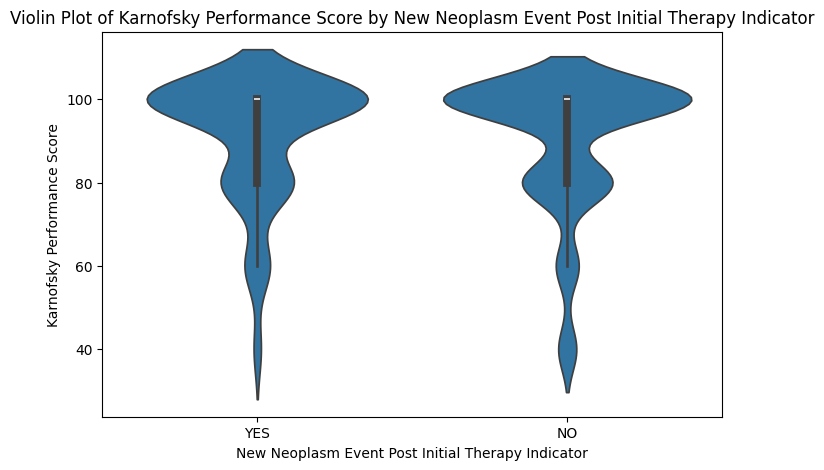

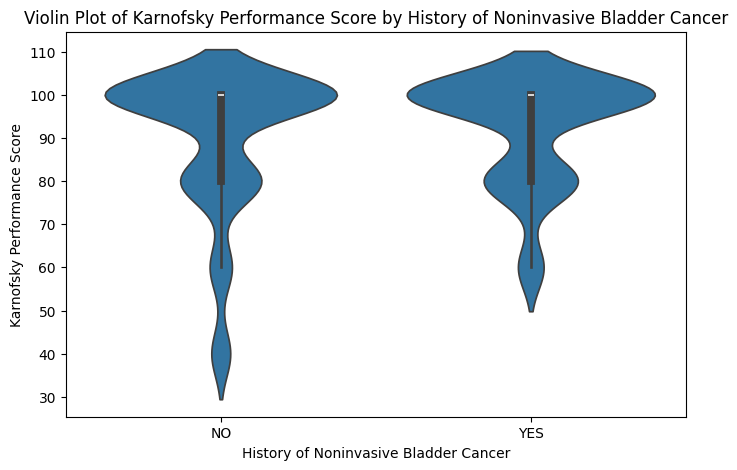

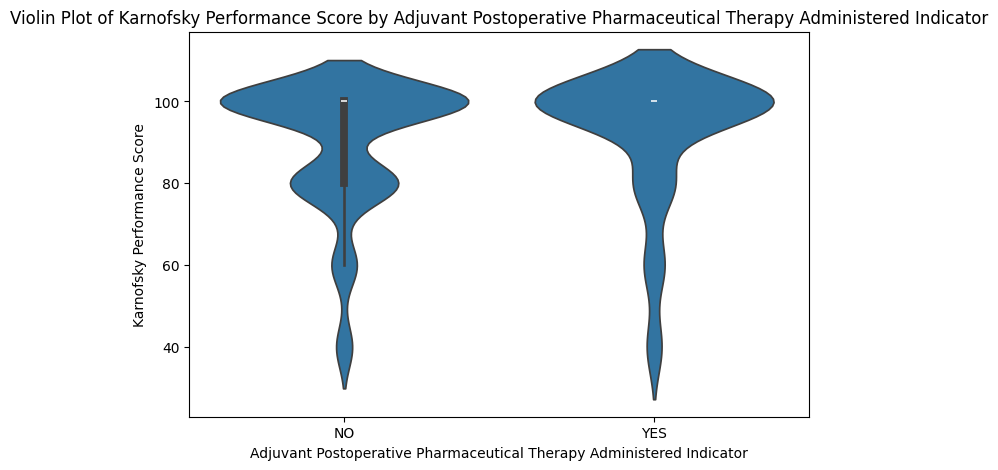

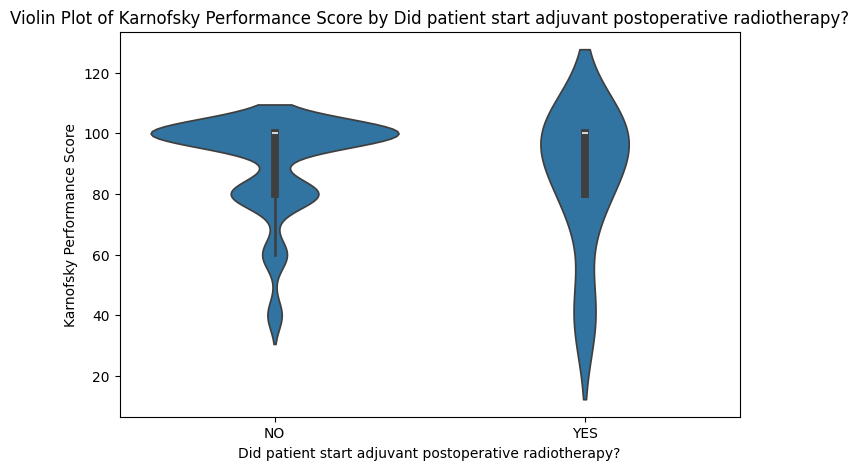

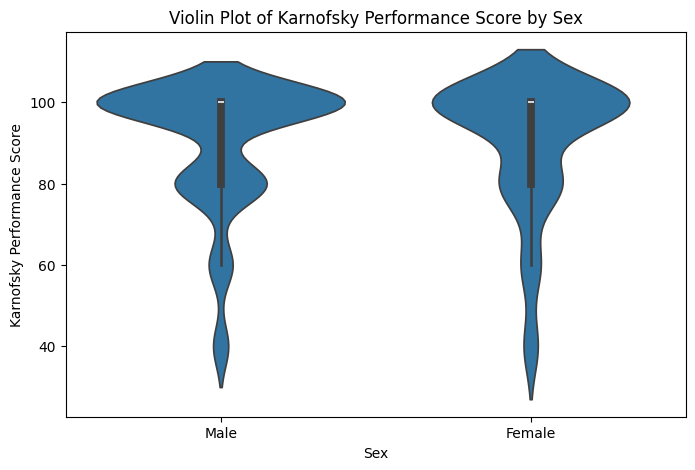

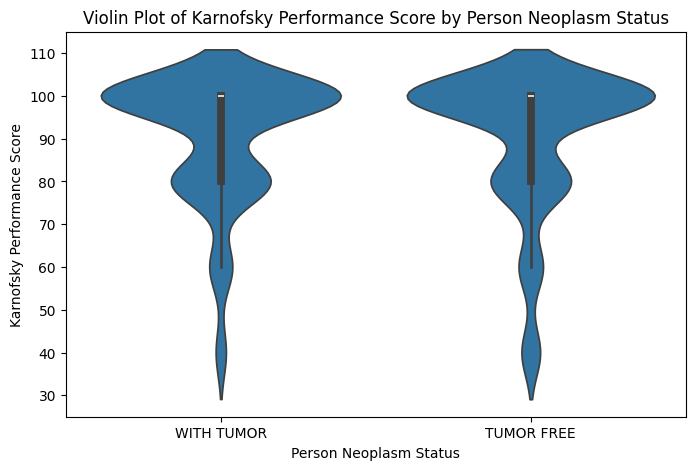

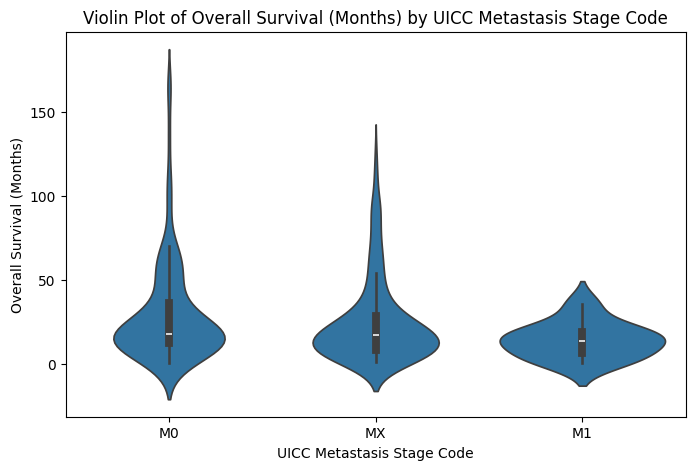

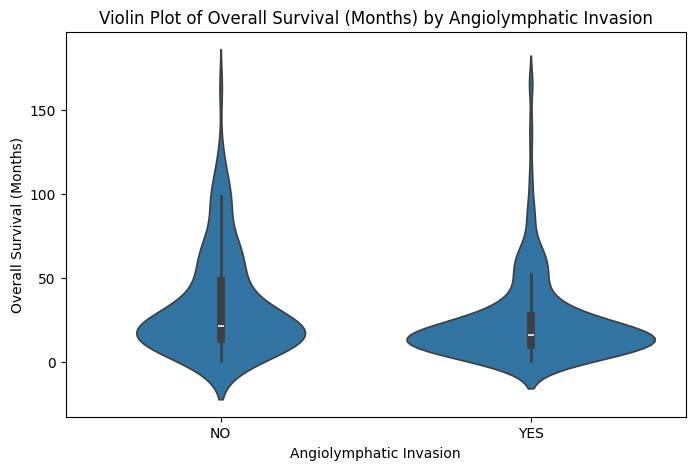

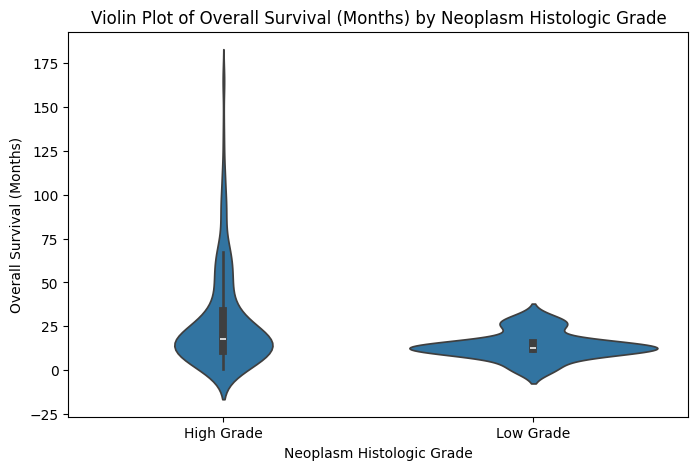

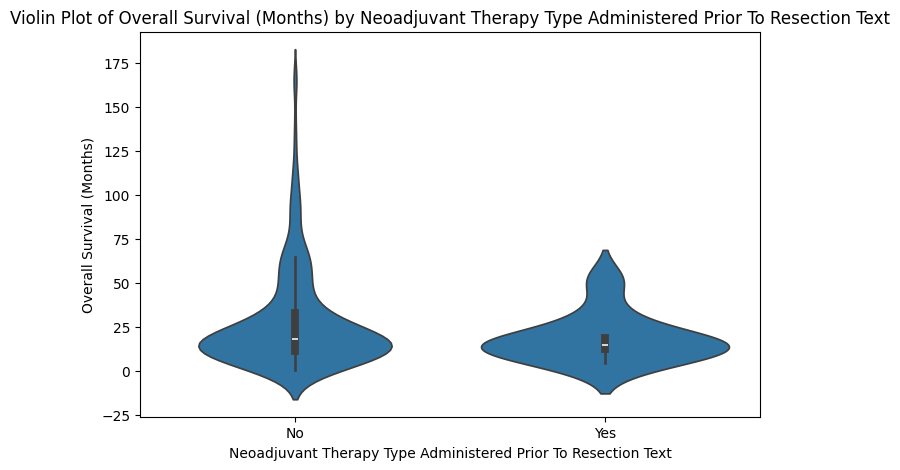

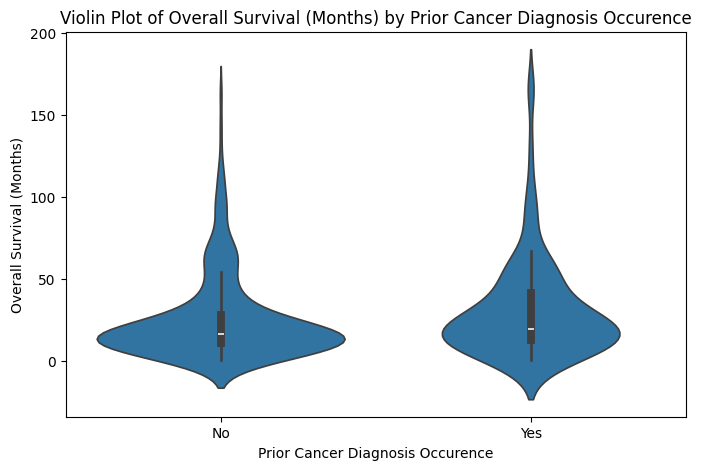

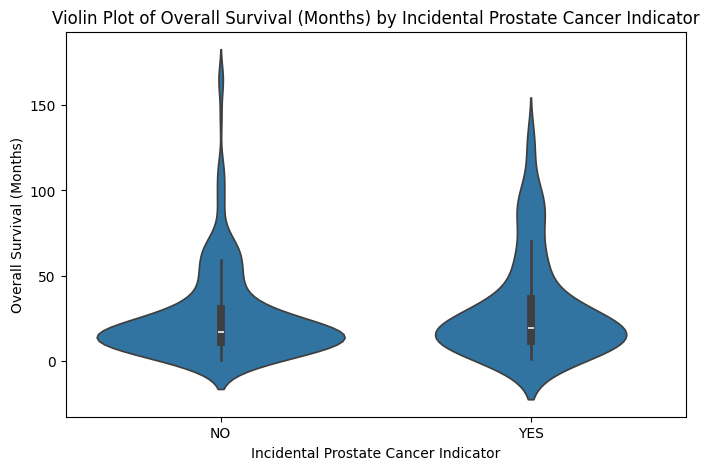

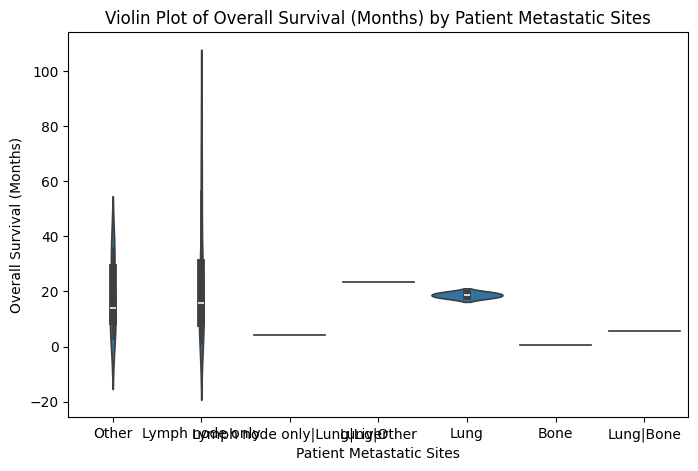

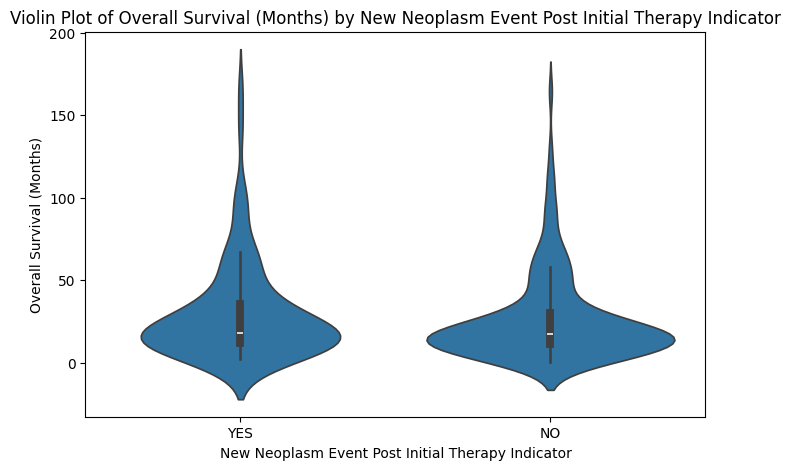

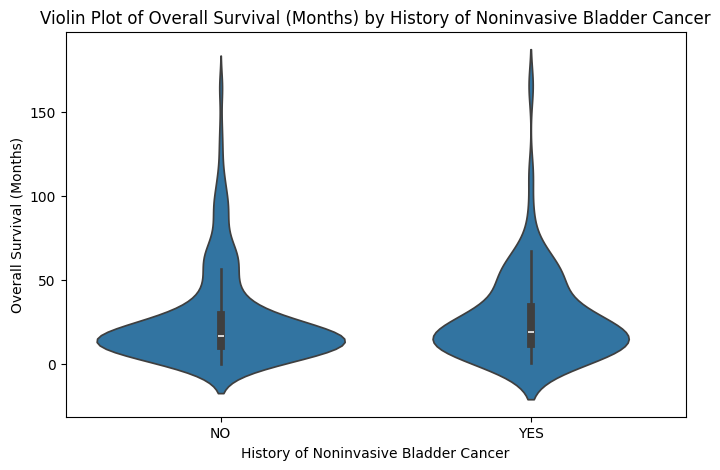

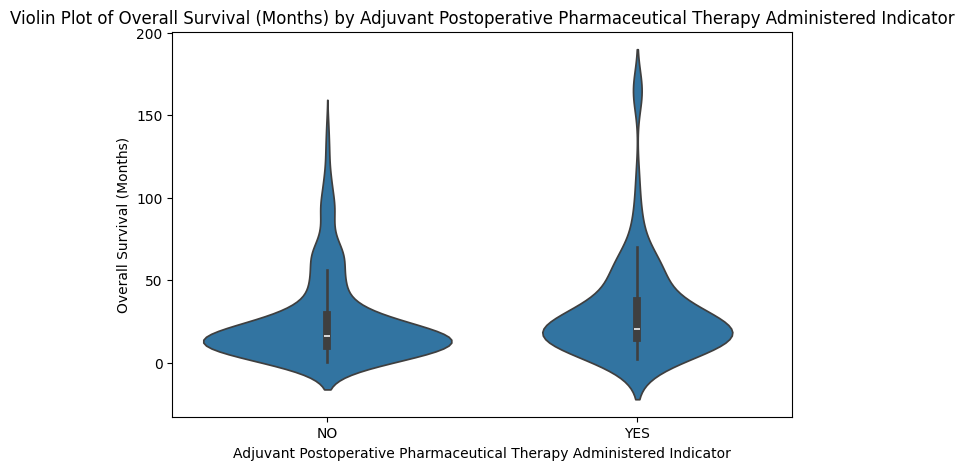

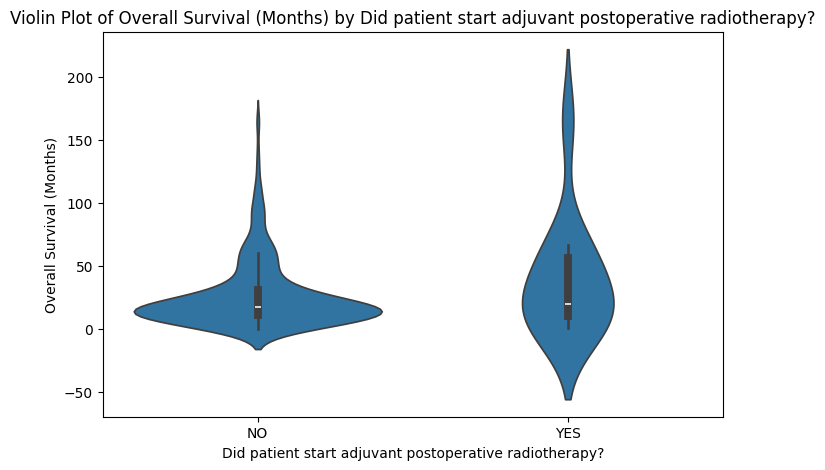

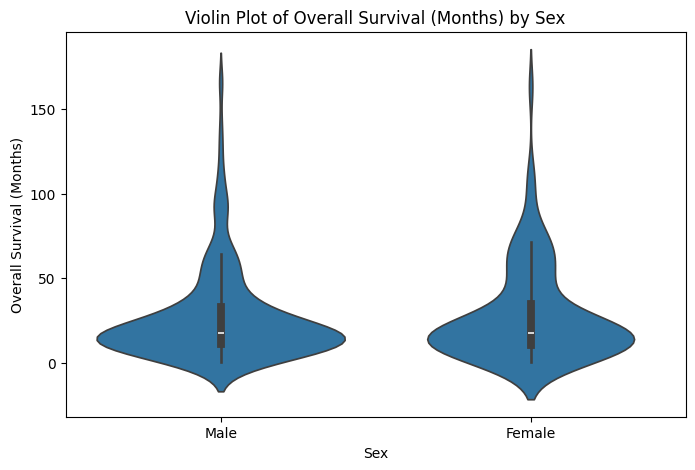

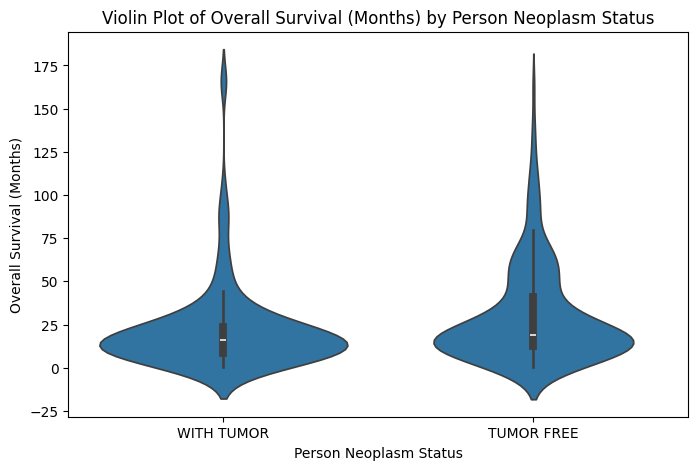

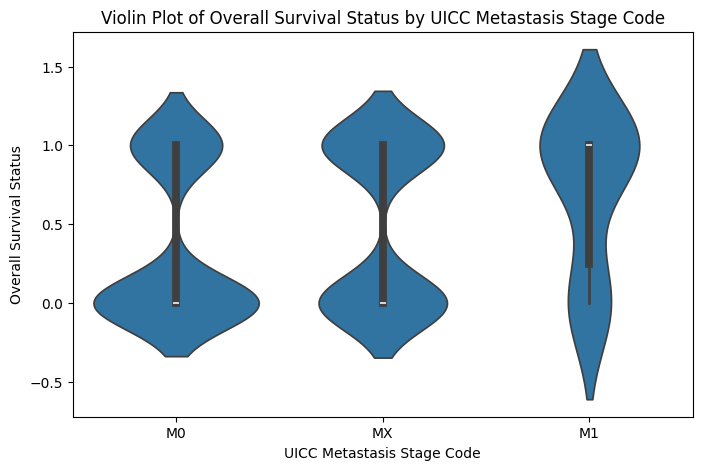

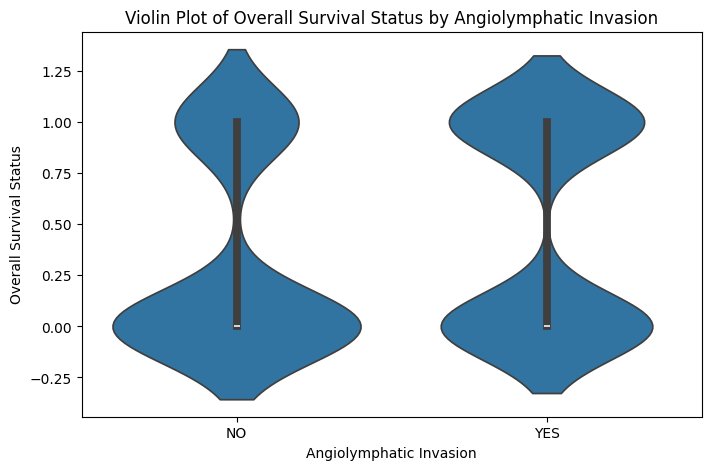

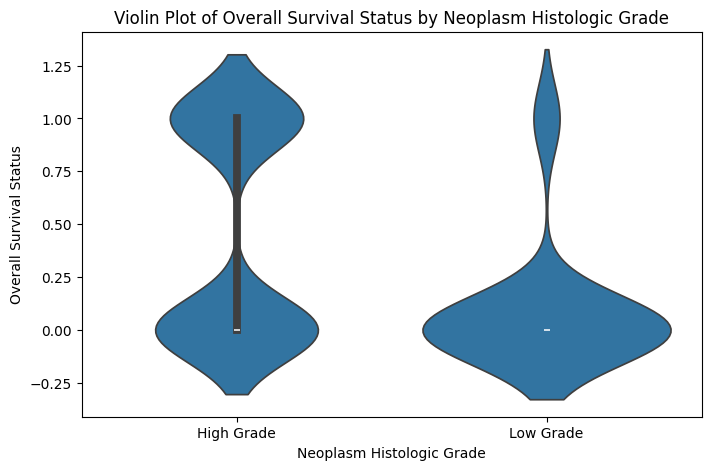

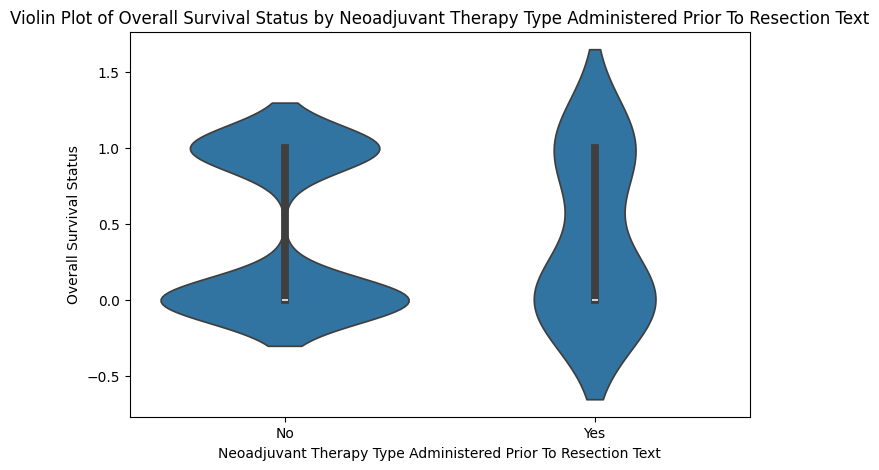

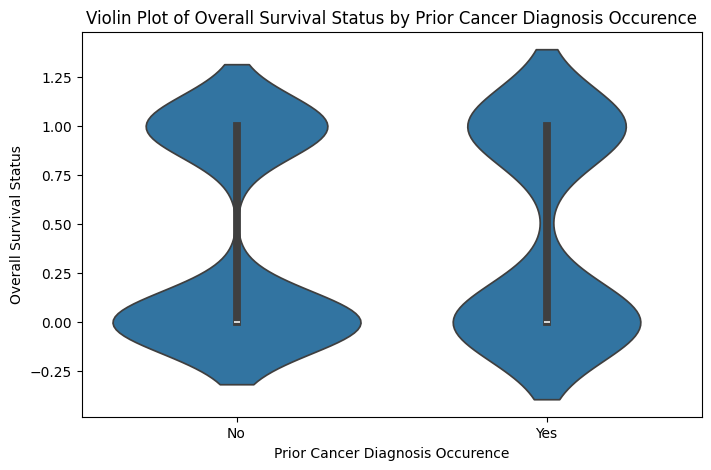

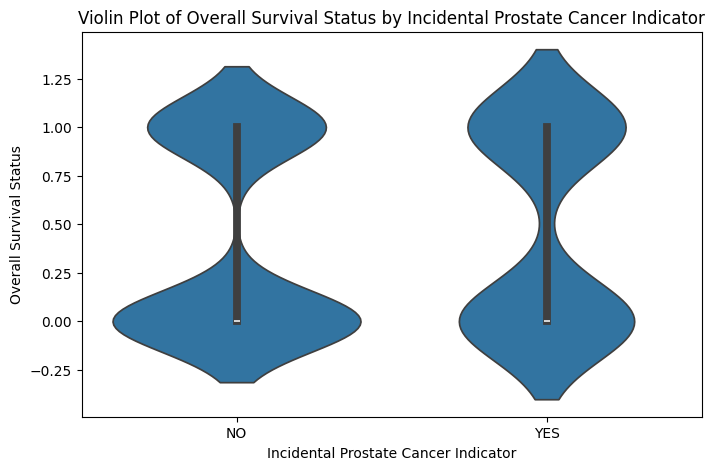

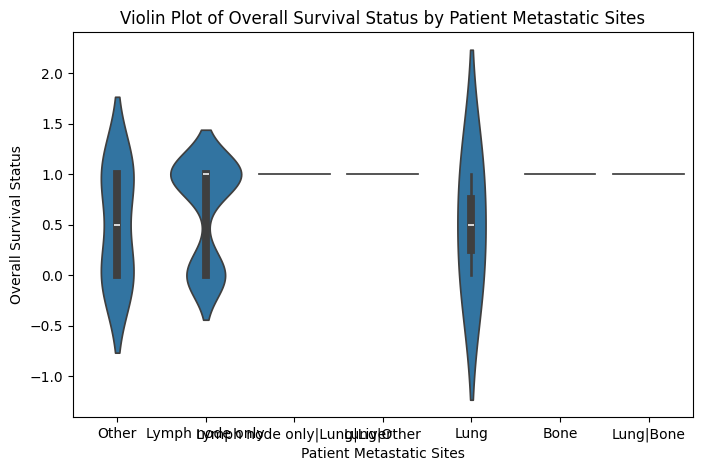

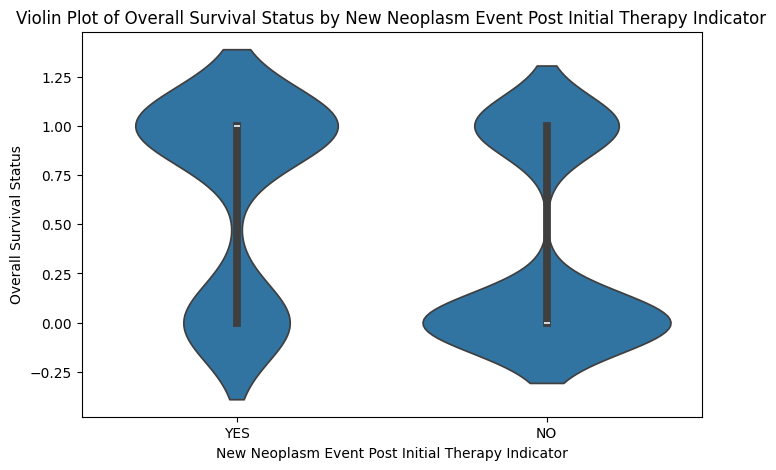

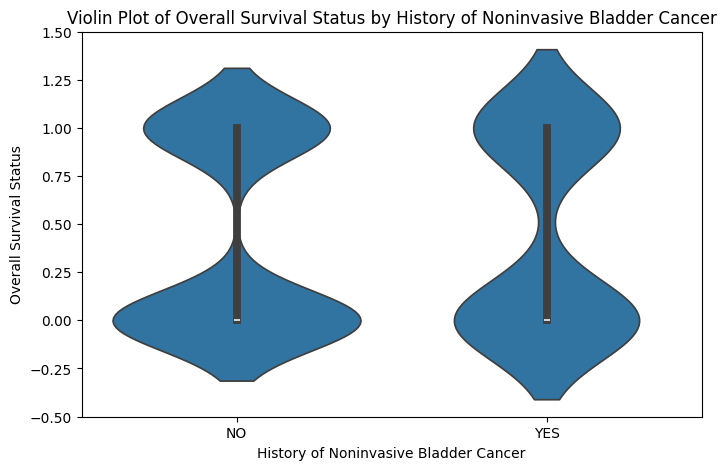

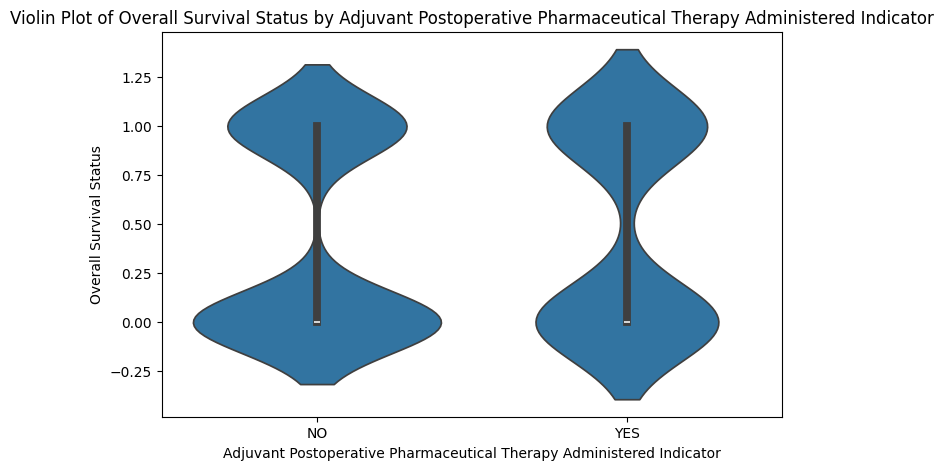

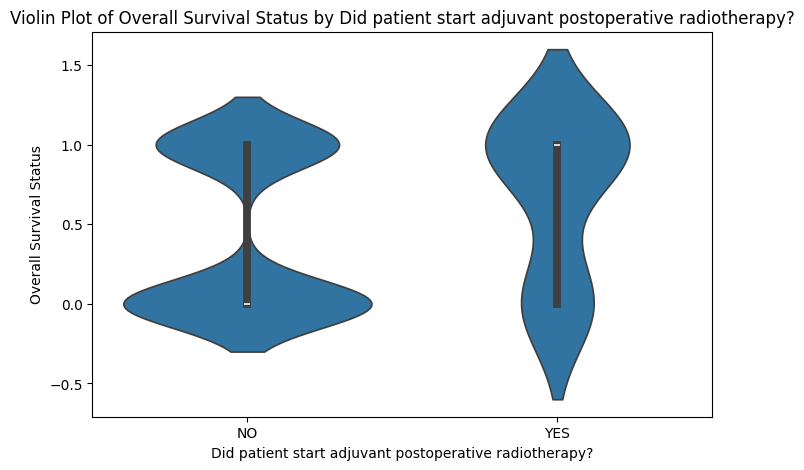

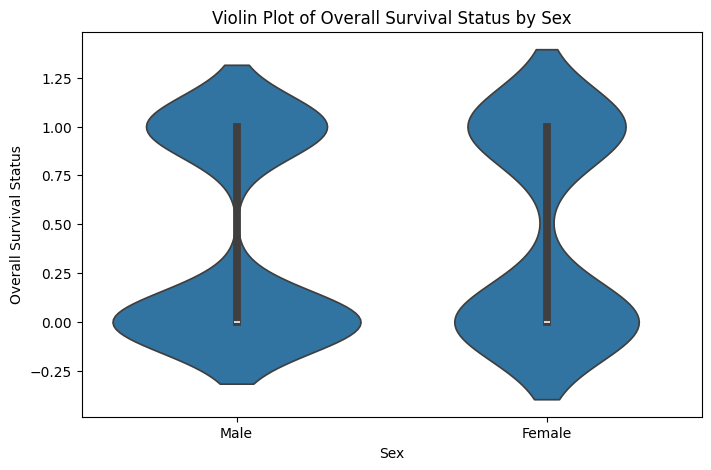

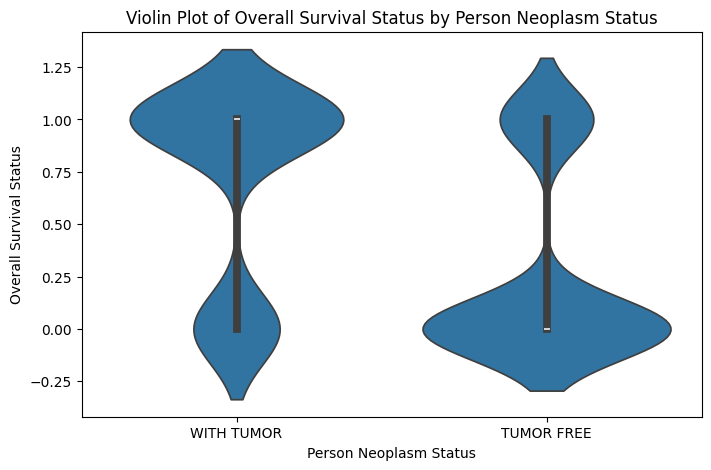

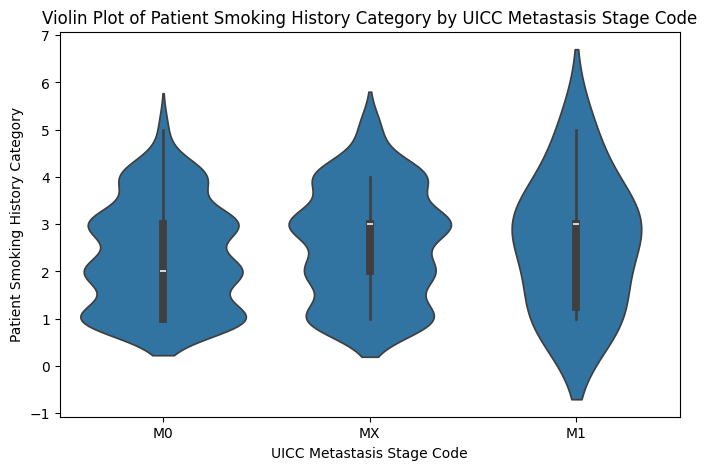

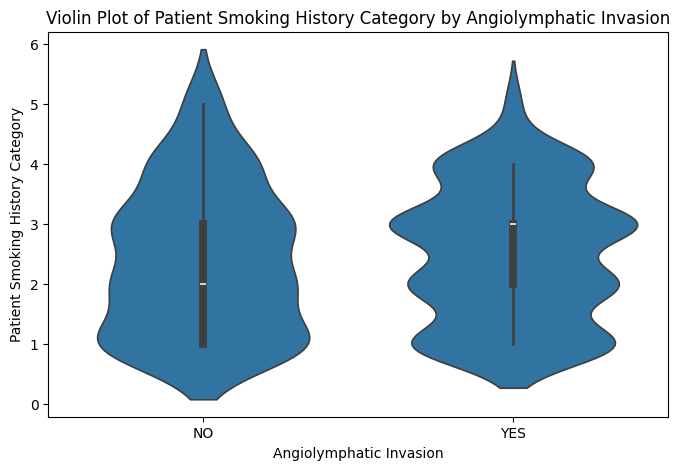

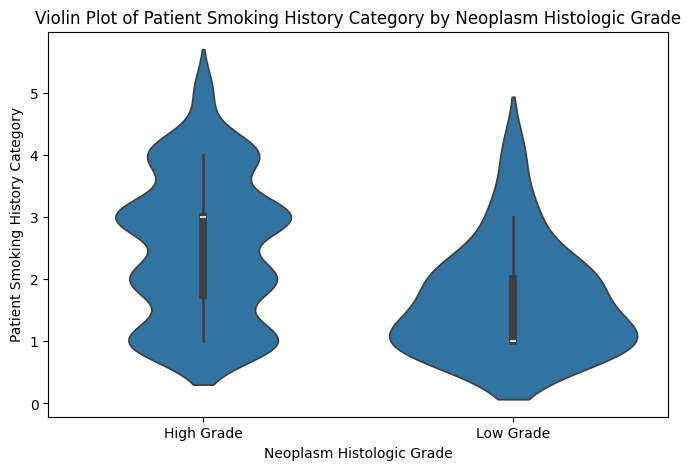

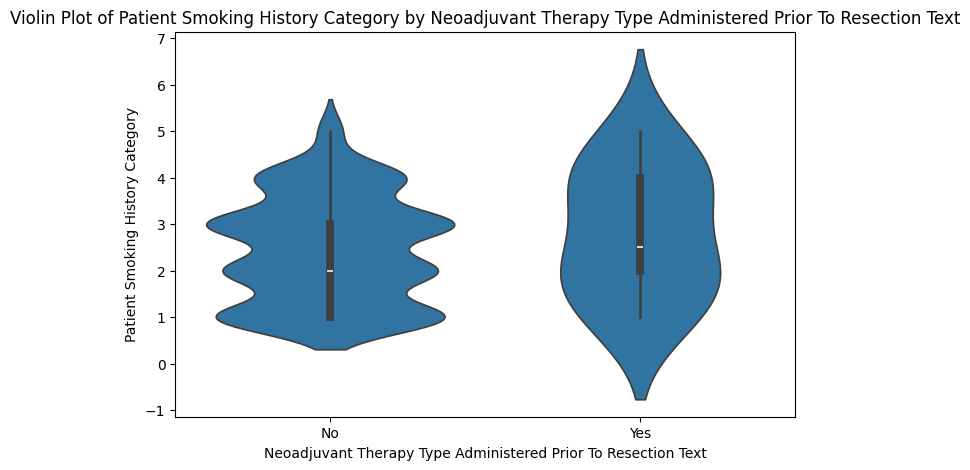

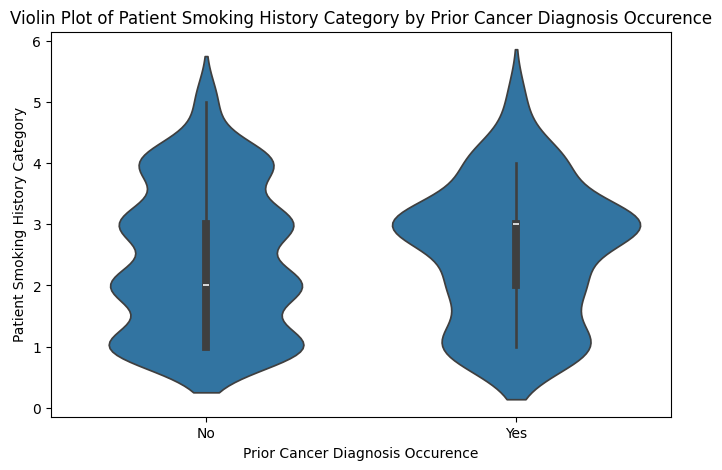

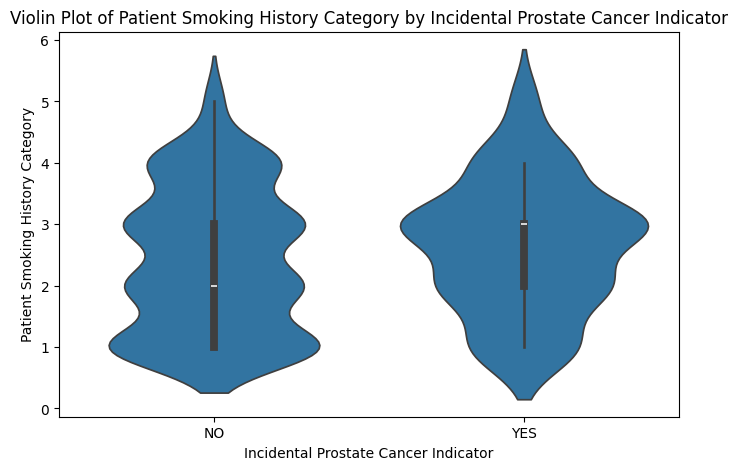

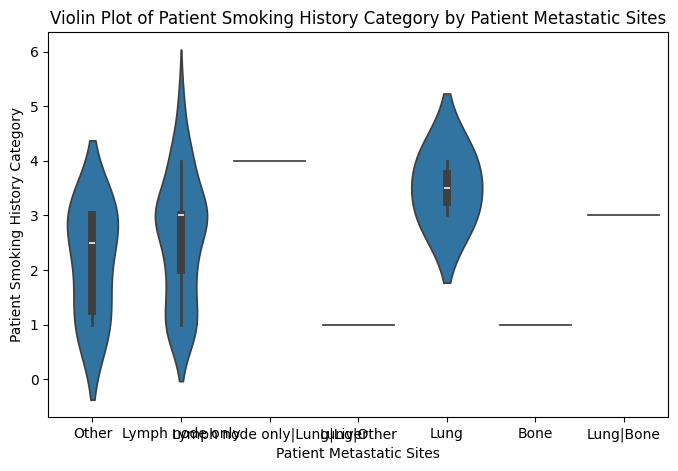

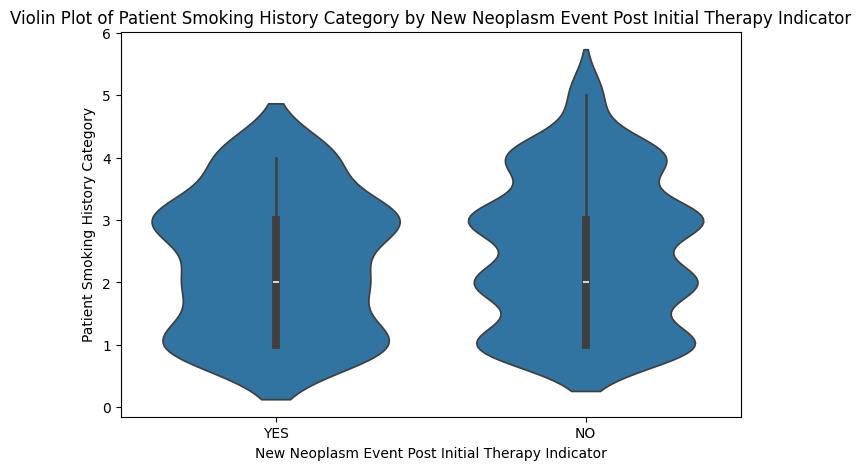

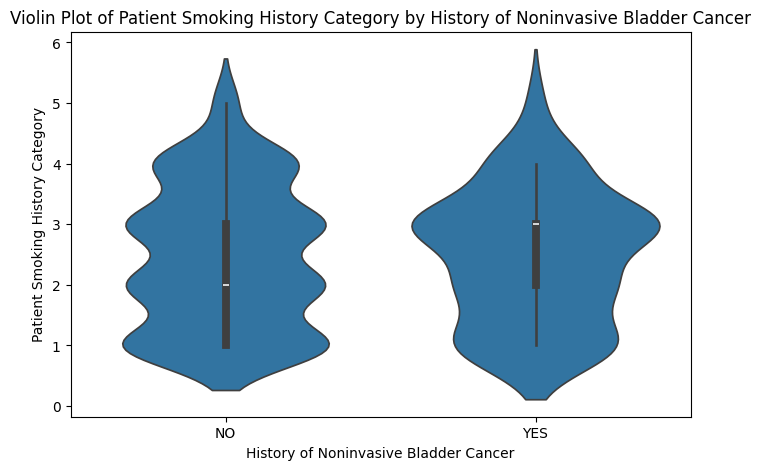

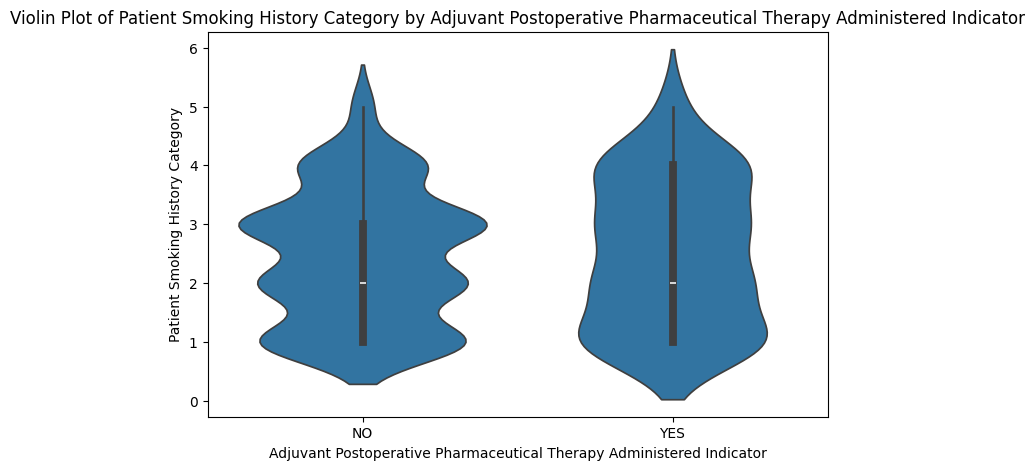

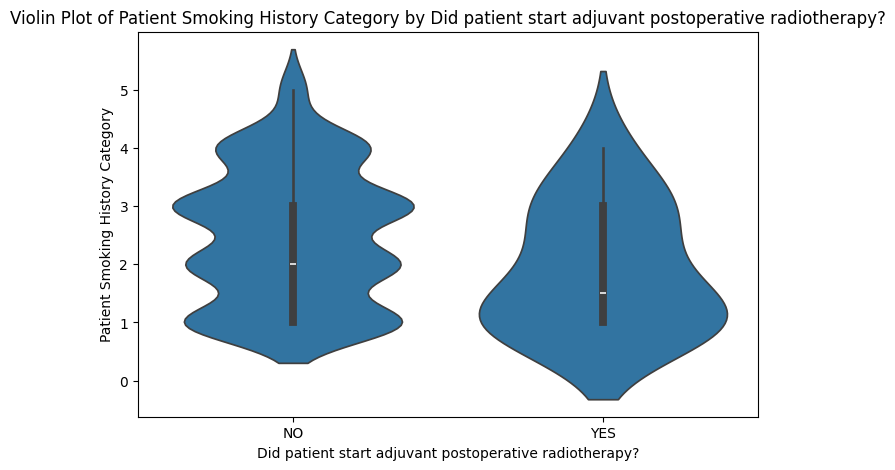

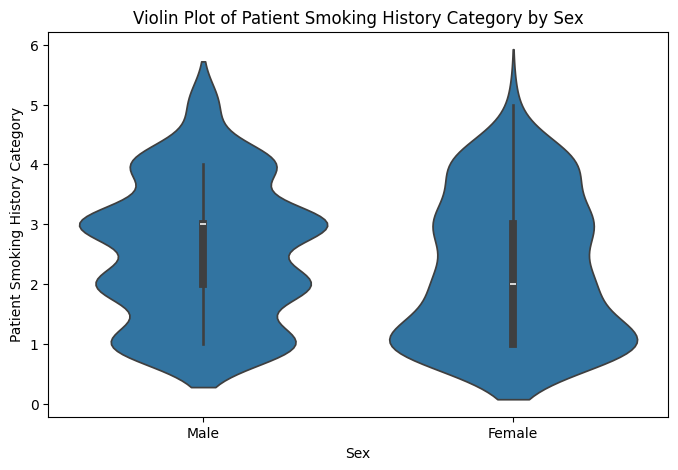

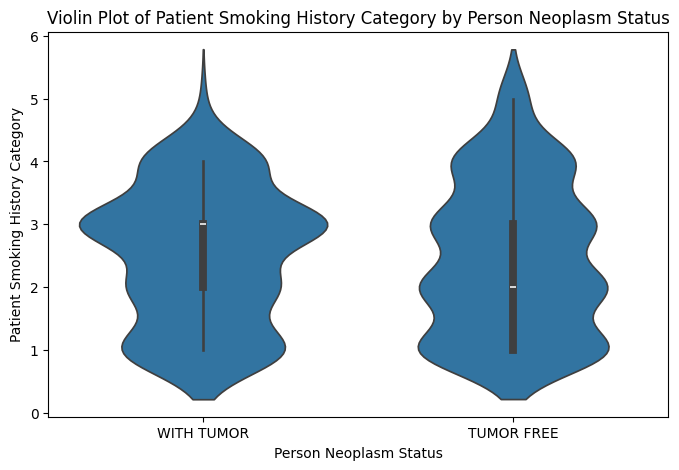

✅ All visualizations generated and saved in /content/question_6


In [35]:
# Step 1: Load dataset
df = second.copy()
# Step 2: Automatically detect variable types
num_vars = df.select_dtypes(include=['number']).columns.tolist()
cat_vars = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

# Step 3: Create output directory
output_dir = '/content/question_6'
os.makedirs(output_dir, exist_ok=True)

# Step 4: Histograms for numerical variables
for col in num_vars:
    plt.figure(figsize=(8, 5))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.savefig(f"{output_dir}/histogram_{col.replace(' ', '_')}.png")
    plt.show()
    plt.close()

# Step 5: Box plots for numerical variables
for col in num_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.savefig(f"{output_dir}/boxplot_{col.replace(' ', '_')}.png")
    plt.show()
    plt.close()

# Step 7: Bar charts for categorical variables
for col in cat_vars:
    plt.figure(figsize=(8, 5))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"Bar Chart of {col}")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.savefig(f"{output_dir}/bar_chart_{col.replace(' ', '_')}.png")
    plt.show()
    plt.close()

# Step 8: Pie charts for categorical variables
for col in cat_vars:
    plt.figure(figsize=(6, 6))
    df[col].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap="Set3")
    plt.title(f"Pie Chart of {col}")
    plt.ylabel("")
    plt.savefig(f"{output_dir}/pie_chart_{col.replace(' ', '_')}.png")
    plt.show()
    plt.close()

# Step 9: Violin plots for all numeric-categorical pairs (optional)
for num_col in num_vars:
    for cat_col in cat_vars:
        if df[cat_col].nunique() > 1 and df[cat_col].nunique() < 10:  # Avoid too many categories
            plt.figure(figsize=(8, 5))
            sns.violinplot(x=cat_col, y=num_col, data=df)
            plt.title(f"Violin Plot of {num_col} by {cat_col}")
            plt.xlabel(cat_col)
            plt.ylabel(num_col)
            plt.savefig(f"{output_dir}/violin_{num_col.replace(' ', '_')}_{cat_col.replace(' ', '_')}.png")
            plt.show()
            plt.close()

print("✅ All visualizations generated and saved in /content/question_6")
